In [1]:
#***************************************************************************************
# Name: Jonah Zembower
# Date: 5/4/2024
# Final Project for Applied Stats and Modeling
#***************************************************************************************

### Loading in Packages:

In [158]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)

### Function Creation:
This is to help the reproducibility of the code throughout each dataset.

In [4]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [5]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [6]:
#Create a function that is going to make a bar chart
def bar_chart(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.bar(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [7]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    """
    Function to plot the seasonal decomposition of a time series.

    Parameters:
    - data: Pandas Series or DataFrame with a datetime index.
    - freq: Frequency of the seasonal component (e.g., 'D' for daily, 'M' for monthly).

    Returns:
    - None (plots the decomposition).
    """
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

In [9]:
#Create a for loop that replaces the missing values within the mean value
def missing_values_replace(days_replace,data,first_row,last_row):
    for day in days_replace:
        replace_value = data[first_row:last_row][day].mean()
        data.loc[last_row,day] = replace_value
    return data

In [10]:
#Create a rolling mean of the data to understand the trend
#This also incudes the standard deviation to understand the variance in data values

def roll_mean_std_dev(df_column,window):

    plt.figure(figsize=(10,6))
    #Look at the mean and the standard deviation of this data
    rolmean = df_column.rolling(window).mean()
    rolstd = df_column.rolling(window).std()

    #Let's check the stationarity of the graph
    #Plot the rolling statistics
    orig = plt.plot(df_column,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std = plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [11]:
# to interpret hourly data
def create_hourly_data(df, value_column, incrementing_column):
    # List of hours in a week (0-167)
    hours_of_week = ['Hour ' + str(i) for i in range(168)]

    # Make a copy of the DataFrame
    original_copy = df.copy()
    original_copy['Incrementing Hour'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column, inplace=True)

    # Determine the number of weeks (assuming a week has 168 hours)
    num_weeks = (len(df) + 167) // 168

    # Create a new DataFrame where the index is the number of weeks and the columns are the hours of the week
    hourly_data = pd.DataFrame(index=range(num_weeks), columns=hours_of_week)

    # Fill the empty DataFrame with data
    for i, row in original_copy.iterrows():
        week = i // 168
        hour = 'Hour ' + str(i % 168)
        hourly_data.at[week, hour] = row[value_column]

    return hourly_data


In [12]:
#When given a list of daily values it may be useful to break it up into weeks as rows and days as columns
#This is going to help be able to break up the data and perform statistical analysis
def create_weekly_data(df,value_column,incrementing_column):
    
    #Create the list of days as the column names
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    #Make a copy
    original_copy = df.copy()
    original_copy['Incrementing Day'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column,inplace=True)

    #Determine the number of weeks by adding 6 to the length so that partial weeks are counted
    num_weeks = (len(df)+6) // 7

    #Create a new datadrame where the index is the number of weeks and the columns are the days of the week
    weekly_data = pd.DataFrame(index=range(num_weeks),columns=days_of_week)

    #Fill the empty dataframe with data
    for i, row in original_copy.iterrows():
        week = i // 7
        day = days_of_week[i % 7]
        weekly_data.at[week, day] = row[value_column]

    return weekly_data

In [13]:
#When given a list of daily values which do not include weekend values such as stock data 
#it can be useful to break it up into weeks as rows and days as columns
#This can break up the data to perform statistical analysis

def create_week_day_data(df,value_column,incrementing_column):
    
    #Create the list of days as the column names
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    #Make a copy
    original_copy = df.copy()
    original_copy['Incrementing Day'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column,inplace=True)

    #Determine the number of weeks by adding 6 to the length so that partial weeks are counted
    num_weeks = (len(df)+4) // 5

    #Create a new datadrame where the index is the number of weeks and the columns are the days of the week
    weekly_data = pd.DataFrame(index=range(num_weeks),columns=days_of_week)

    #Fill the empty dataframe with data
    for i, row in original_copy.iterrows():
        week = i // 5
        day = days_of_week[i % 5]
        weekly_data.at[week, day] = row[value_column]

    return weekly_data

In [14]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
def create_monthly_data(df,value_column,incrementing_month):

    #Create list of months
    months = ['January','February','March','April','May','June','July','August','September','October','November','December']

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = i // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

In [15]:
# Function to get the MAE for a given dataset
def calculate_mae_with_zeroes(data_series):
    """
    Calculate the Mean Absolute Error (MAE) between a given series of electricity consumption
    data and an array of zeroes of the same length.

    Parameters:
    - data_series (pd.Series): A Pandas Series containing the electricity consumption data.

    Returns:
    - float: The computed MAE.
    """
    # Create a zero array of the same length as the data series
    zeroes = np.zeros(len(data_series))
    
    # Compute the MAE
    mae = mean_absolute_error(data_series, zeroes)
    
    return mae


In [16]:
# Function to get MSE for a given dataset
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_mse_with_zeroes(data_series):
    """
    Calculate the Mean Squared Error (MSE) between a given series of electricity consumption
    data and an array of zeroes of the same length.

    Parameters:
    - data_series (pd.Series): A Pandas Series containing the electricity consumption data.

    Returns:
    - float: The computed MSE.
    """
    # Create a zero array of the same length as the data series
    zeroes = np.zeros(len(data_series))
    
    # Compute the MSE
    mse = mean_squared_error(data_series, zeroes)
    
    return mse


In [17]:
#Plot the seasonal values that make up the decomposition
def seasonal_values_plot(decomposed_data_seasonal,lag_length,y_column,title,xlabel,period_list,ylabel):
    seasonal_data = pd.DataFrame(decomposed_data_seasonal[0:lag_length])
    plt.figure(figsize=(12,6))
    plt.plot(seasonal_data.index,seasonal_data[y_column])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(seasonal_data.index,period_list)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)

In [18]:
#Find statistical information and add it onto the dataframe
#This is used for weekly data (Monday-Sunday)
def mean_median_variance_std_weekly(data, columns):

    num_weeks = len(data)

    data['Weekly Mean'] = data.sum(axis=1)/7
    data['Weekly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_weeks,len(data))
    columns_to_select = slice(7,11)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [19]:
# To do the mean, median, std, variance for each hour of each week
def create_hourly_statistics(df, value_column, incrementing_column):
    # List of hours in a week (0-167)
    hours_of_week = ['Hour ' + str(i) for i in range(168)]

    # Make a copy of the DataFrame
    original_copy = df.copy()
    original_copy['Incrementing Hour'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column, inplace=True)

    # Determine the number of weeks (assuming a week has 168 hours)
    num_weeks = (len(df) + 167) // 168

    # Create a dictionary to collect lists of values for each hour
    hourly_values = {hour: [] for hour in hours_of_week}

    # Collect all values in lists under each hour
    for i, row in original_copy.iterrows():
        hour = 'Hour ' + str(i % 168)
        hourly_values[hour].append(row[value_column])

    # Calculate statistics
    stats = ['mean', 'median', 'std', 'variance']
    hourly_stats = pd.DataFrame(index=hours_of_week, columns=stats)

    # Compute mean, median, std, and variance for each hour
    for hour in hours_of_week:
        if hourly_values[hour]:
            hourly_stats.at[hour, 'mean'] = np.mean(hourly_values[hour])
            hourly_stats.at[hour, 'median'] = np.median(hourly_values[hour])
            hourly_stats.at[hour, 'std'] = np.std(hourly_values[hour], ddof=1)  # sample standard deviation
            hourly_stats.at[hour, 'variance'] = np.var(hourly_values[hour], ddof=1)  # sample variance
        else:
            hourly_stats.at[hour, 'mean'] = np.nan
            hourly_stats.at[hour, 'median'] = np.nan
            hourly_stats.at[hour, 'std'] = np.nan
            hourly_stats.at[hour, 'variance'] = np.nan

    return hourly_stats


In [20]:
#Find statistical information and add it onto the dataframe
#This is used for weekly data (Monday-Sunday)
def mean_median_variance_std_monthly(data, columns):

    num_months = len(data)

    data['Monthly Mean'] = data.sum(axis=1)/7
    data['Monthly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_months,len(data))
    columns_to_select = slice(12,16)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [21]:

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []
    import warnings
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [22]:
def select_best_arima(data, ar_orders, ma_orders, d_orders):
    """
    Selects the best ARIMA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.
    - ma_orders: A list of integers for MA(q) orders to test.
    - d_orders: A list of integers for differencing (d) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    # Generate all combinations of AR, MA, and differencing orders
    orders = list(product(ar_orders, d_orders, ma_orders))

    for order in orders:
        try:
            model = ARIMA(data, order=order)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = order

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = order

        except Exception as e:
            print(f"Error fitting ARIMA{order}: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }

In [23]:
from pmdarima import auto_arima
def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
    
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

In [24]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.scatter(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Load the Data Files:

In [25]:
# Load the data files
dinosaur_park = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Applied Statistics and Modeling/Projects/Final Project/DinosaurPark.txt')
electricity_consumption = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Applied Statistics and Modeling/Projects/Final Project/electricity_consumption_data.csv')
sunspots = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Applied Statistics and Modeling/Projects/Final Project/Sunspots.csv')
website_traffic = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Applied Statistics and Modeling/Projects/Final Project/website_traffic_data.csv')


# Dinosaur Park

This file contains a dataset describing ticket sales at a dinosaur park.

In [26]:
dinosaur_park

,YEAR,MONTH,SALES
0,1992,1,3253
1,1992,2,3042
2,1992,3,3246
3,1992,4,3164
4,1992,5,3210
...,...,...,...
127,2002,8,7489
128,2002,9,6821
129,2002,10,7032
130,2002,11,8310


### Data Preprocessing:

In [27]:
#Convert the year and month columns to datetime

#Create a column of 1's to have it as the first day of the month
Day = np.ones(len(dinosaur_park))
dinosaur_park['DAY'] = Day

date = pd.to_datetime(dinosaur_park[['YEAR','MONTH','DAY']])
dinosaur_park['Date'] = date
dinosaur_park

,YEAR,MONTH,SALES,DAY,Date
0,1992,1,3253,1.0,1992-01-01
1,1992,2,3042,1.0,1992-02-01
2,1992,3,3246,1.0,1992-03-01
3,1992,4,3164,1.0,1992-04-01
4,1992,5,3210,1.0,1992-05-01
...,...,...,...,...,...
127,2002,8,7489,1.0,2002-08-01
128,2002,9,6821,1.0,2002-09-01
129,2002,10,7032,1.0,2002-10-01
130,2002,11,8310,1.0,2002-11-01


In [28]:
# Remove columns
dinosaur_park.drop(columns=['DAY'], inplace=True)
dinosaur_park.drop(columns=['MONTH'], inplace=True)
dinosaur_park.drop(columns=['YEAR'], inplace=True)

# Rename the 'Date' column to 'day'
dinosaur_park.rename(columns={'Date': 'Day'}, inplace=True)

# Convert 'day' to datetime type
dinosaur_park['Day'] = pd.to_datetime(dinosaur_park['Day'])

# Set 'day' as the index
dinosaur_park.set_index('Day', inplace = True)

# Creating some future analysis
dinosaur_park['Incrementing Day'] = range(1, len(dinosaur_park)+1)

# Show modified DataFrame
dinosaur_park

,SALES,Incrementing Day
Day,,
1992-01-01,3253,1
1992-02-01,3042,2
1992-03-01,3246,3
1992-04-01,3164,4
1992-05-01,3210,5
...,...,...
2002-08-01,7489,128
2002-09-01,6821,129
2002-10-01,7032,130


### Exploratory Data Analysis:

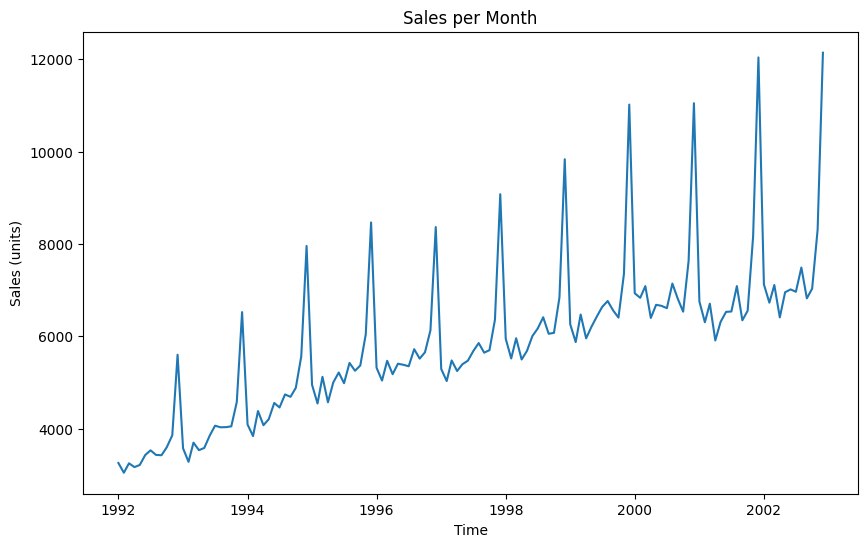

In [29]:
#Plot the time series
time_series(dinosaur_park.index,dinosaur_park['SALES'],'Sales per Month','Time','Sales (units)')

In [30]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
monthly_dinosaur_park_decomposition = decompose_seasonality(dinosaur_park['SALES'],12)

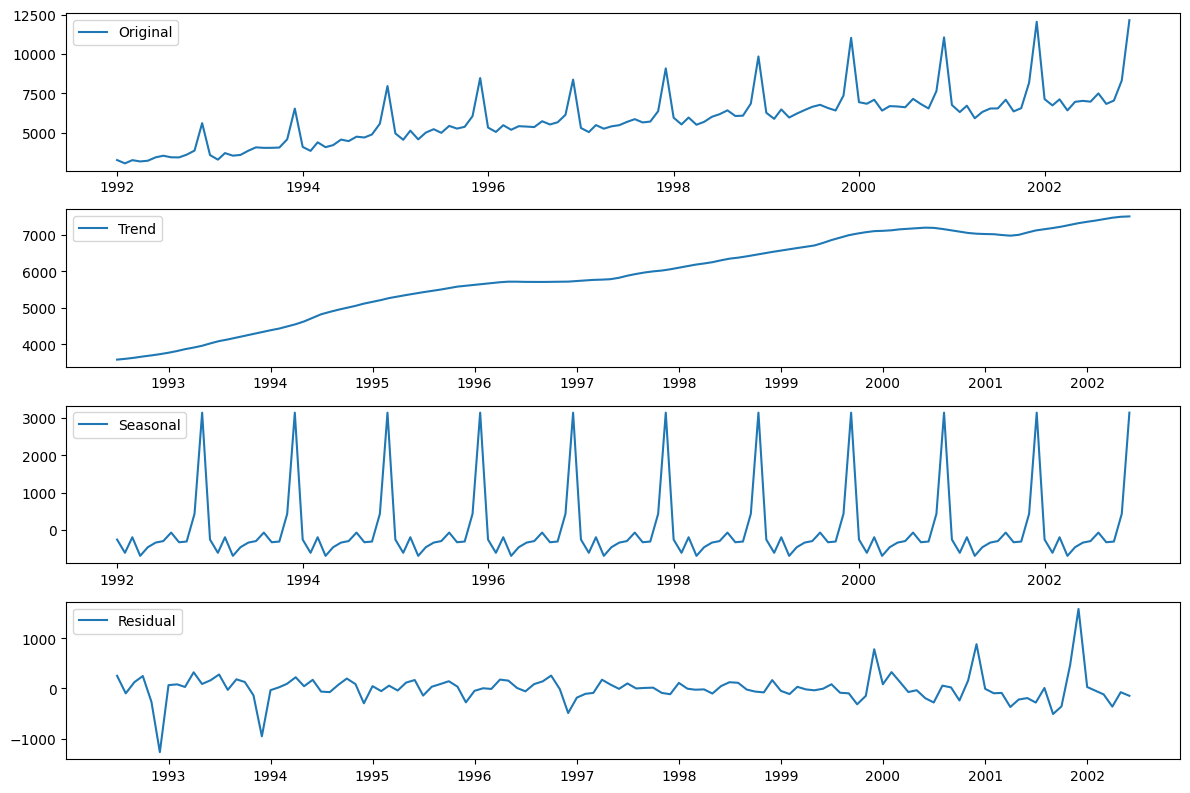

In [31]:
#Plot the seasonal decomposition of dinosaur_park
plot_seasonal_decomposition(dinosaur_park['SALES'],12)

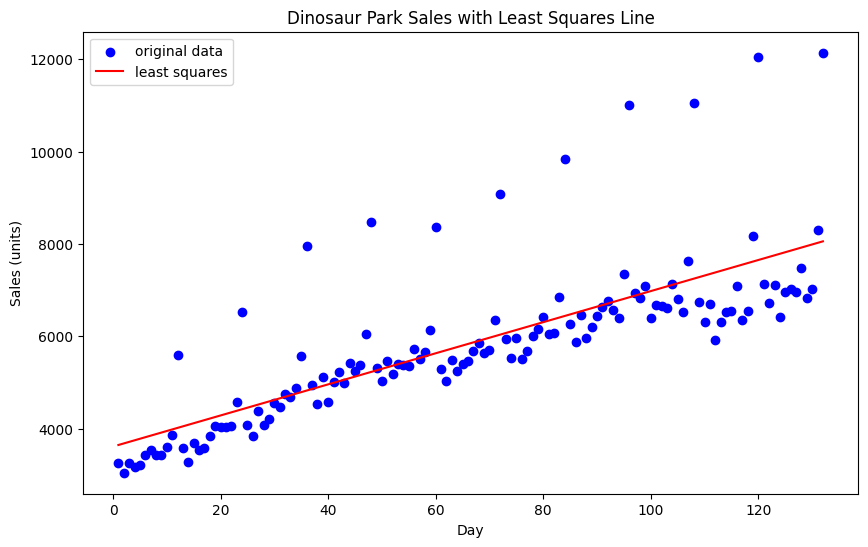

In [32]:
plot_least_squares_line(dinosaur_park['Incrementing Day'][0:132],monthly_dinosaur_park_decomposition[0],
                        'Dinosaur Park Sales with Least Squares Line','Day','Sales (units)')

In [33]:
#Create a new data frame that has monthly data
#This is going to make it easier to draw statistics from the data based on its seasonality
dinosaur_park_monthly = create_monthly_data(dinosaur_park,'SALES','Incrementing Month')
dinosaur_park_monthly

,January,February,March,April,May,June,July,August,September,October,November,December
0,3253,3042,3246,3164,3210,3426,3527,3428,3421,3595,3853,5598
1,3571,3278,3694,3531,3579,3847,4061,4027,4030,4047,4572,6523
2,4087,3836,4379,4072,4202,4554,4456,4738,4687,4880,5566,7956
3,4946,4542,5120,4568,4998,5214,4982,5422,5252,5366,6043,8466
4,5317,5040,5467,5177,5404,5381,5349,5719,5515,5652,6128,8366
5,5289,5029,5475,5246,5394,5471,5676,5852,5644,5698,6359,9078
6,5945,5518,5956,5496,5681,6005,6167,6411,6053,6073,6840,9836
7,6258,5873,6470,5954,6204,6430,6636,6763,6558,6403,7352,11020
8,6931,6832,7086,6396,6681,6658,6608,7142,6809,6532,7636,11050
9,6752,6303,6706,5908,6312,6528,6536,7087,6345,6552,8168,12042


In [34]:
# Getting general statistics for the sunspots_monthly dataframe
dinosaur_park_statistics = mean_median_variance_std_monthly(dinosaur_park_monthly,columns=['January','February','March','April','May','June','July','August','September','October','November','December'])
dinosaur_park_statistics

/var/folders/5v/l60713ps6gz1y72cj6ls8g_w0000gn/T/ipykernel_69166/748762367.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data.iloc[rows_to_select,columns_to_select] = pd.np.nan


,January,February,March,April,May,June,July,August,September,October,November,December,Monthly Mean,Monthly Median,Standard Deviation,Variance
0,3253,3042,3246,3164,3210,3426,3527,3428,3421,3595,3853,5598,6109.000000,3423.5,676.665549,4.578763e+05
1,3571,3278,3694,3531,3579,3847,4061,4027,4030,4047,4572,6523,6965.714286,3937.0,845.937386,7.156101e+05
2,4087,3836,4379,4072,4202,4554,4456,4738,4687,4880,5566,7956,8201.857143,4505.0,1097.457264,1.204412e+06
3,4946,4542,5120,4568,4998,5214,4982,5422,5252,5366,6043,8466,9274.142857,5167.0,1040.978426,1.083636e+06
4,5317,5040,5467,5177,5404,5381,5349,5719,5515,5652,6128,8366,9787.857143,5435.5,881.590140,7.772012e+05
5,5289,5029,5475,5246,5394,5471,5676,5852,5644,5698,6359,9078,10030.142857,5559.5,1071.135969,1.147332e+06
6,5945,5518,5956,5496,5681,6005,6167,6411,6053,6073,6840,9836,10854.428571,6029.0,1163.764825,1.354349e+06
7,6258,5873,6470,5954,6204,6430,6636,6763,6558,6403,7352,11020,11703.000000,6450.0,1375.723950,1.892616e+06
8,6931,6832,7086,6396,6681,6658,6608,7142,6809,6532,7636,11050,12337.285714,6820.5,1257.548996,1.581429e+06
9,6752,6303,6706,5908,6312,6528,6536,7087,6345,6552,8168,12042,12177.000000,6544.0,1652.353590,2.730272e+06


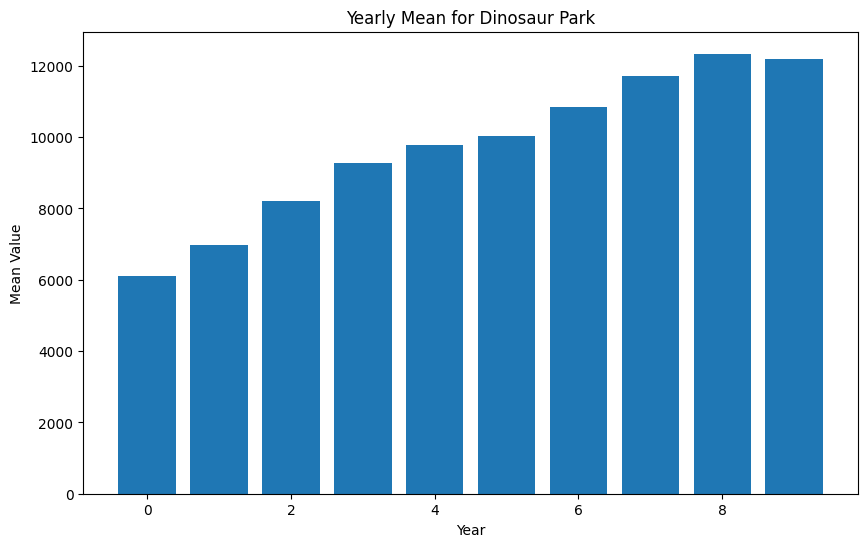

In [35]:
# Create a bar chart of the mean of the values of each month
bar_chart(dinosaur_park_statistics.index[0:10],dinosaur_park_statistics['Monthly Mean'][0:10],'Yearly Mean for Dinosaur Park','Year','Mean Value')

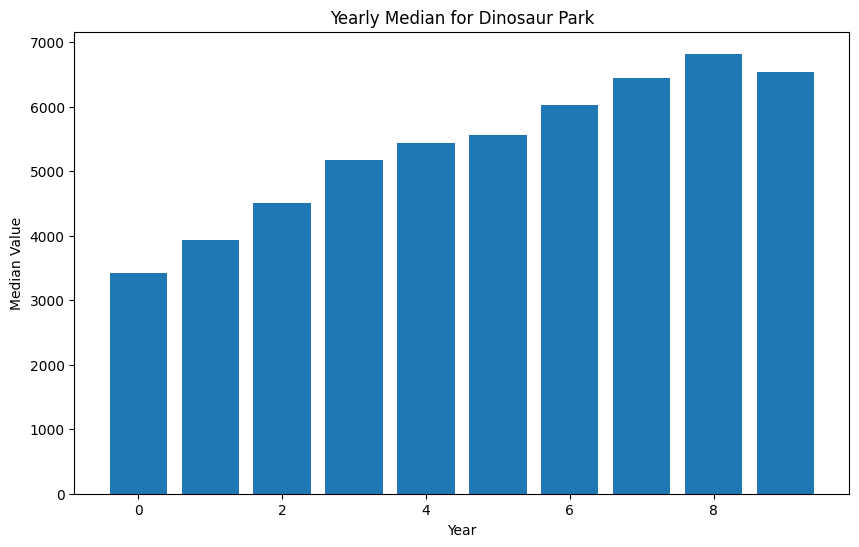

In [36]:
# Create a bar chart of the mean of the values of each month
bar_chart(dinosaur_park_statistics.index[0:10],dinosaur_park_statistics['Monthly Median'][0:10],'Yearly Median for Dinosaur Park','Year','Median Value')

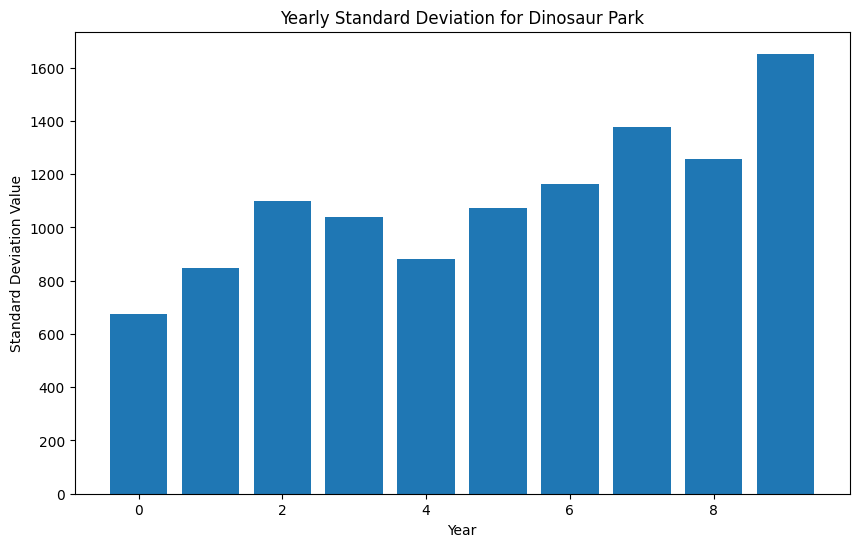

In [37]:
# Create a bar chart of the mean of the values of each month
bar_chart(dinosaur_park_statistics.index[0:10],dinosaur_park_statistics['Standard Deviation'][0:10],'Yearly Standard Deviation for Dinosaur Park','Year','Standard Deviation Value')

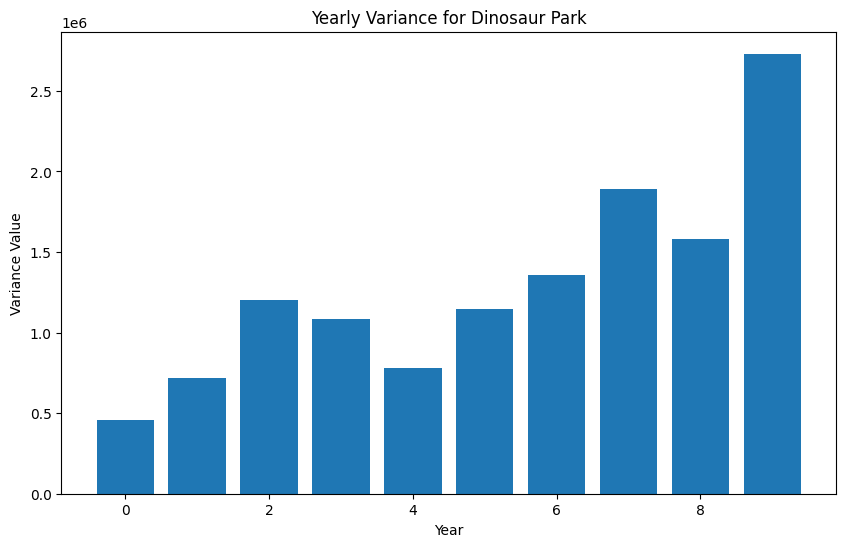

In [38]:
# Create a bar chart of the mean of the values of each month
bar_chart(dinosaur_park_statistics.index[0:10],dinosaur_park_statistics['Variance'][0:10],'Yearly Variance for Dinosaur Park','Year','Variance Value')

### ARIMA Model Building:

Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

Components of Box-Jenkins Models:
- p: Autoregressive (AR) order for non-seasonal component.

- d: Differencing order for non-seasonal component.

- q: Moving average (MA) order for non-seasonal component.

- P: Autoregressive (AR) order for seasonal component.

- D: Differencing order for seasonal component.

- Q: Moving average (MA) order for seasonal component.

- s: Seasonal period (e.g., 12 for monthly data, 4 for quarterly data).

AIC Model Explanation:
- Formulation: AIC is calculated as 2k - 2ln(L), where k is the number of paramters and ln(L) is the log of the likelihood model
- Purpose: AIC selets a model that is most accurate in underlying mechanisms that generates the observed data
- Penalty for complexity: It penalises the complexity based on the number of parameters
- Assumption: Does not require assumptions

BIC Model Explanation:
- Formulation: BIC = ln(n)k - 2ln(L) where n is the same size and k is the number of parameters, and ln(L) is the log likelihood
- Purpose: aims to select the most true model based on certain assumptions
- Penalty: BIC places penalty on number of parameters in the model, more than in AIC
- Assumption: BIC is derived from Bayesian probability

#### q order for dinosaur park

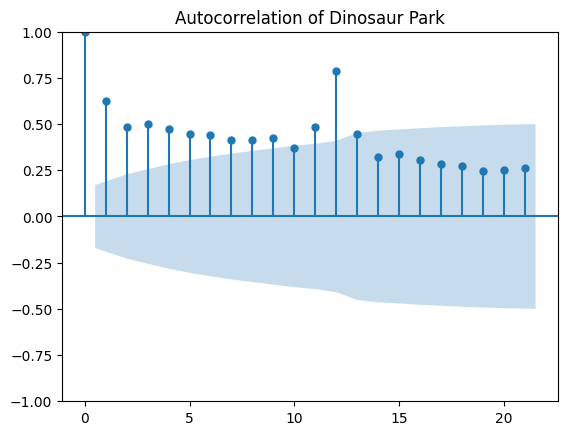

In [39]:
#Plot the ACF values
acf_values_dinosaur_park = plot_acf(dinosaur_park['SALES'], lags=21,title='Autocorrelation of Dinosaur Park')

In [40]:
# q order for dinosaur park
q_orders_dinosaur_park = [1,2,3,4,12]

#### p order for dinosaur park

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


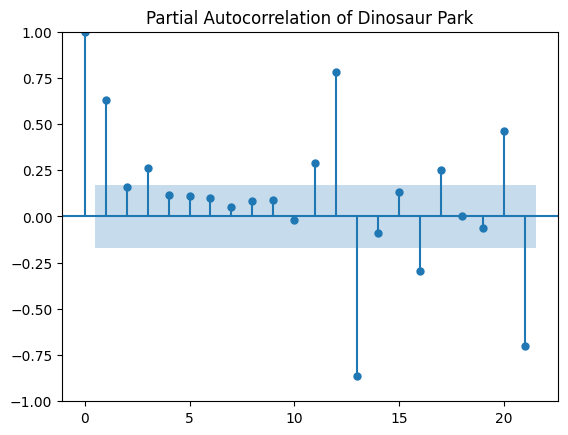

In [41]:
#Plot the PACF values
pacf_values_dinosaur_park = plot_pacf(dinosaur_park['SALES'],lags=21,title='Partial Autocorrelation of Dinosaur Park')

In [42]:
# p orders for dinosaur park
p_orders_dinosaur_park = [1,3,12,13,21]

#### d order for dinosaur park

In [43]:
# doing the ADF test
adf_test(dinosaur_park['SALES'])

ADF Statistic:  -2.0886889021224113
P-Value:  0.24908710762761804
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [44]:
#Create a new column that takes the first difference of dinosaur park
dinosaur_park['First Difference'] = dinosaur_park['SALES'].diff()
dinosaur_park = dinosaur_park[1::]
adf_test(dinosaur_park['First Difference'])

ADF Statistic:  -2.974811306466105
P-Value:  0.03731460738055117
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


Based on the reduced p-value, I believe that we can move on without needing more differences. 

In [45]:
# orders for d
d_orders_dinosaur_park = [1,2]

#### Removing Seasonality from data for P,D,Q

In [46]:
#Create the new series which has seasonal components removed from the data
monthly_dinosaur_park_seasonal_removed = monthly_dinosaur_park_decomposition[0] - monthly_dinosaur_park_decomposition[2]
monthly_dinosaur_park_seasonal_removed

Day
1992-01-01    3510.861458
1992-02-01    3655.298958
1992-03-01    3441.886458
1992-04-01    3859.073958
1992-05-01    3672.765625
                 ...     
2002-08-01    7559.957292
2002-09-01    7150.911458
2002-10-01    7343.128125
2002-11-01    7878.340625
2002-12-01    9001.090625
Length: 132, dtype: float64

#### Q order for dinosaur park

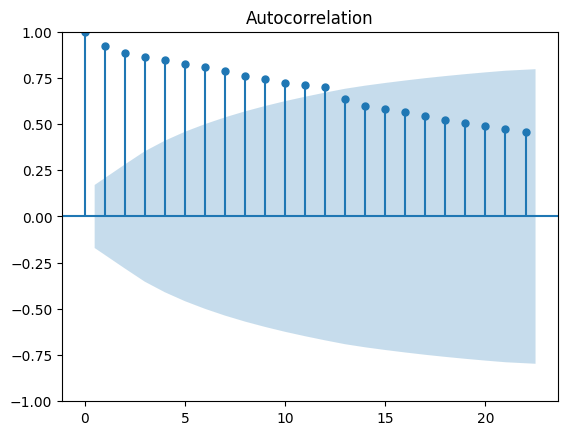

In [47]:
#Plot the new acf
acf_values_dinosaur_park_seasonal_adjusted = plot_acf(monthly_dinosaur_park_seasonal_removed)

In [48]:
# orders for Q
Q_orders_dinosaur_park = [1,2,3,4,5]

#### P order for dinosaur park

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


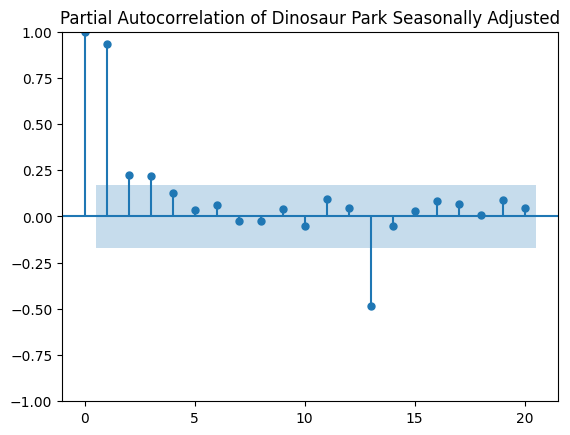

In [49]:
#Plot the PACF values
pacf_values_dionsaur_park_seasonal_adjusted = plot_pacf(monthly_dinosaur_park_seasonal_removed, lags = 20, title = 'Partial Autocorrelation of Dinosaur Park Seasonally Adjusted')

In [50]:
# Order for P
P_orders_dinosaur_park = [1,2,3,13]

#### D order for dinosaur park

In [51]:
# ADF test for dinosaur park
adf_test(monthly_dinosaur_park_seasonal_removed)

ADF Statistic:  -1.9682637697112113
P-Value:  0.3006592939358801
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [52]:
# I need to difference the seasonally removed data for dinosaur park
dinosaur_park['Seasonal Difference'] = dinosaur_park['SALES'].diff(12)
adf_result_seasonal = adfuller(dinosaur_park['Seasonal Difference'].dropna())
adf_result_seasonal[1]

/var/folders/5v/l60713ps6gz1y72cj6ls8g_w0000gn/T/ipykernel_69166/130489868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dinosaur_park['Seasonal Difference'] = dinosaur_park['SALES'].diff(12)


0.0019414484409474373

In [53]:
# Order for D
D_orders_dinosaur_park = [1,2]

### Forecasting:

Do Holt's Winter's Method as well as ARIMA and SARIMA and compare. Holt's Winter's Method looks like it will work well for this data. 

Parameters for Box Jenkins Models
- q: 1,2,3,4,12
- p: 1,3,12,13,21
- d: 1,2
- Q: 1,2,3,4,5
- P: 1,2,3,13
- D: 1,2
- s: 12

ARIMA model:

In [54]:

warnings.filterwarnings("ignore")

# Looking at the best AR, MA, And d components for ARIMA models
model_arima = evaluate_time_series_models(dinosaur_park['SALES'], p_orders_dinosaur_park, q_orders_dinosaur_park, d_orders_dinosaur_park)
model_arima.head()

,Model,Order,AIC,BIC
56,ARIMA,"(12, 1, 2)",1835.347004,1878.360020
55,ARIMA,"(12, 1, 1)",1835.954159,1876.099641
65,ARIMA,"(13, 1, 1)",1836.878179,1879.891196
57,ARIMA,"(12, 1, 3)",1837.212225,1883.092777
66,ARIMA,"(13, 1, 2)",1837.883957,1883.764509


SARIMA model:

In [55]:
warnings.filterwarnings("ignore")

# Going through all combinations to find the best sarima model based on AIC and BIC
select_best_sarima_model(dinosaur_park['SALES'], p_orders_dinosaur_park, d_orders_dinosaur_park, q_orders_dinosaur_park, P_orders_dinosaur_park, D_orders_dinosaur_park, Q_orders_dinosaur_park, 12)

{'aic': 1605.8159531637225,
 'bic': 1614.1280070371195,
 'pdq': (0, 1, 2),
 'seasonal_pdq': (0, 1, 0, 12)}

Holt's Winters Method:

In [56]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Split data into training and testing sets (let's use the last 12 months as test data)
train_data = dinosaur_park['SALES'][:-12]
test_data = dinosaur_park['SALES'][-12:]

In [57]:
# Fit Holt-Winters models: additive and multiplicative
hw_additive = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()
hw_multiplicative = ExponentialSmoothing(train_data, seasonal='mul', seasonal_periods=12).fit()

# Forecast the next 12 months
additive_forecast = hw_additive.forecast(12)
multiplicative_forecast = hw_multiplicative.forecast(12)

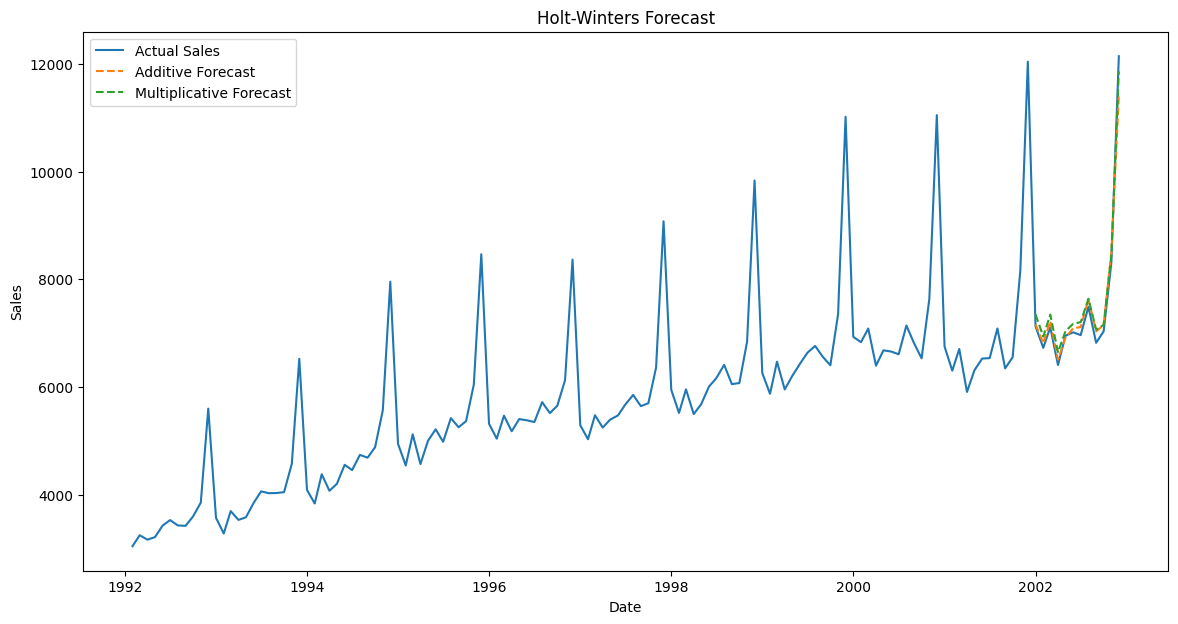

In [58]:
plt.figure(figsize=(14, 7))
plt.plot(dinosaur_park['SALES'], label='Actual Sales')
plt.plot(additive_forecast, label='Additive Forecast', linestyle='--')
plt.plot(multiplicative_forecast, label='Multiplicative Forecast', linestyle='--')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Evaluation of forecasts:
- Actual Sales show clear seasonal peaks and some variability in magnitude over the years.
- Additive Forecast seems to capture the seasonality well but might not fully capture the varying amplitude of the peaks, which become more pronounced in later years.
- Multiplicative Forecast also follows the seasonal pattern closely and appears to slightly adjust to changes in the amplitude, potentially providing a better fit where the seasonal effect grows or shrinks proportionally with the level of sales.

In [59]:
# AIC and BIC for additive model
additive_aic = hw_additive.aic
additive_bic = hw_additive.bic

# AIC and BIC for multiplicative model
multiplicative_aic = hw_multiplicative.aic
multiplicative_bic = hw_multiplicative.bic

print(f"Additive Model: AIC = {additive_aic}, BIC = {additive_bic}")
print(f"Multiplicative Model: AIC = {multiplicative_aic}, BIC = {multiplicative_bic}")


Additive Model: AIC = 1331.8879454436233, BIC = 1370.7956743471848
Multiplicative Model: AIC = 1254.504626726799, BIC = 1293.4123556303605


Best Model Selection:
- ARIMA: (12,1,2)
  - AIC: 1835.347004
  - BIC: 1878.360020
- SARIMA = (0,1,2) (0,1,0,12)
  - AIC: 1605.8159531637225
  - BIC: 1614.1280070371195
- Holt's Winters Method Additive
  - AIC: 1331.8879454436233
  - BIC: 1370.7956743471848
- Holt's Winters Method Multiplicative
  - AIC: 1254.504626726799
  - BIC: 1293.4123556303605

The Holt's Winters Model multiplicative is the best method for the forecasting since it has the lowest AIC and BIC.

### Model Evaluation:

In [60]:
# Calculate MAE and RMSE for Multiplicative Model
mae_mul = mean_absolute_error(test_data, multiplicative_forecast)
rmse_mul = np.sqrt(mean_squared_error(test_data, multiplicative_forecast))

print(f"Multiplicative Model: MAE = {mae_mul}, RMSE = {rmse_mul}")


Multiplicative Model: MAE = 193.94917568808424, RMSE = 202.4778968095392


- Model Limitations and Discrepancies
  - Seasonality Assumption: Holt-Winters models assume that the seasonal pattern will repeat identically over time. This may not hold true if the seasonal pattern evolves.
  - Linear and Exponential Trends: The method is limited to linear or exponential trends, which might not adequately model more complex trend patterns that could occur in real-world scenarios.
  - Overfitting: While Holt-Winters can fit historical data well, it can overfit, especially with noisy data series or when seasonality and trends are unstable.
  - Parameter Sensitivity: The performance of the model can be highly sensitive to the settings of its parameters (alpha, beta, gamma). Improper tuning can lead to poor forecasts.
- Observing Discrepancies
  - Mismatch in Peak Timing: If the forecast consistently misaligns with the timing of actual peaks, this might suggest a need for a model that can adjust more dynamically to changes in seasonality.
  - Underestimation or Overestimation: The model may consistently underestimate or overestimate during certain periods, indicating potential issues with how the model handles trend or seasonal adjustments.

# Electricity Consumption

In [61]:
electricity_consumption

,Date,Electricity_Consumption
0,2020-01-01 00:00:00,134.183010
1,2020-01-01 01:00:00,67.498984
2,2020-01-01 02:00:00,140.533978
3,2020-01-01 03:00:00,27.359333
4,2020-01-01 04:00:00,50.032748
...,...,...
35036,2023-12-30 20:00:00,109.420824
35037,2023-12-30 21:00:00,200.915641
35038,2023-12-30 22:00:00,45.851352
35039,2023-12-30 23:00:00,35.032760


This dataset contains information on electricity usage.

The instances are of every hour from 2020 to 2023. I will aggregate the data to make it more readable on a time series graph.

### Data Preprocessing:

In [62]:
electricity_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35041 entries, 0 to 35040
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     35041 non-null  object 
 1   Electricity_Consumption  35041 non-null  float64
dtypes: float64(1), object(1)
memory usage: 547.6+ KB


In [63]:
electricity_consumption.isnull().sum()

Date                       0
Electricity_Consumption    0
dtype: int64

### Exploratory Data Analysis:

There appear to be no issues concerning the datetime format or null values. I will now proceed to aggreagte the data towards a datetime format. 

To do this, I will show the weekly averages, monthly averages to get an idea of what time interval to choose for the dataset. 

In [64]:
# Convert 'Date' column to datetime and set it as the index
electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'])
electricity_consumption.set_index('Date', inplace=True)

# Resample the data to daily, weekly, and monthly averages
daily_data = electricity_consumption.resample('D').mean()
weekly_data = electricity_consumption.resample('W').mean()
monthly_data = electricity_consumption.resample('M').mean()

# Display the first few rows of each aggregated data
daily_data.head(), weekly_data.head(), monthly_data.head()


(            Electricity_Consumption
 Date                               
 2020-01-01                71.950062
 2020-01-02                46.067968
 2020-01-03                71.692392
 2020-01-04                58.118983
 2020-01-05                52.920006,
             Electricity_Consumption
 Date                               
 2020-01-05                60.149882
 2020-01-12                59.969732
 2020-01-19                53.892248
 2020-01-26                57.529467
 2020-02-02                61.817644,
             Electricity_Consumption
 Date                               
 2020-01-31                58.091727
 2020-02-29                59.511662
 2020-03-31                58.911036
 2020-04-30                61.170366
 2020-05-31                59.501643)

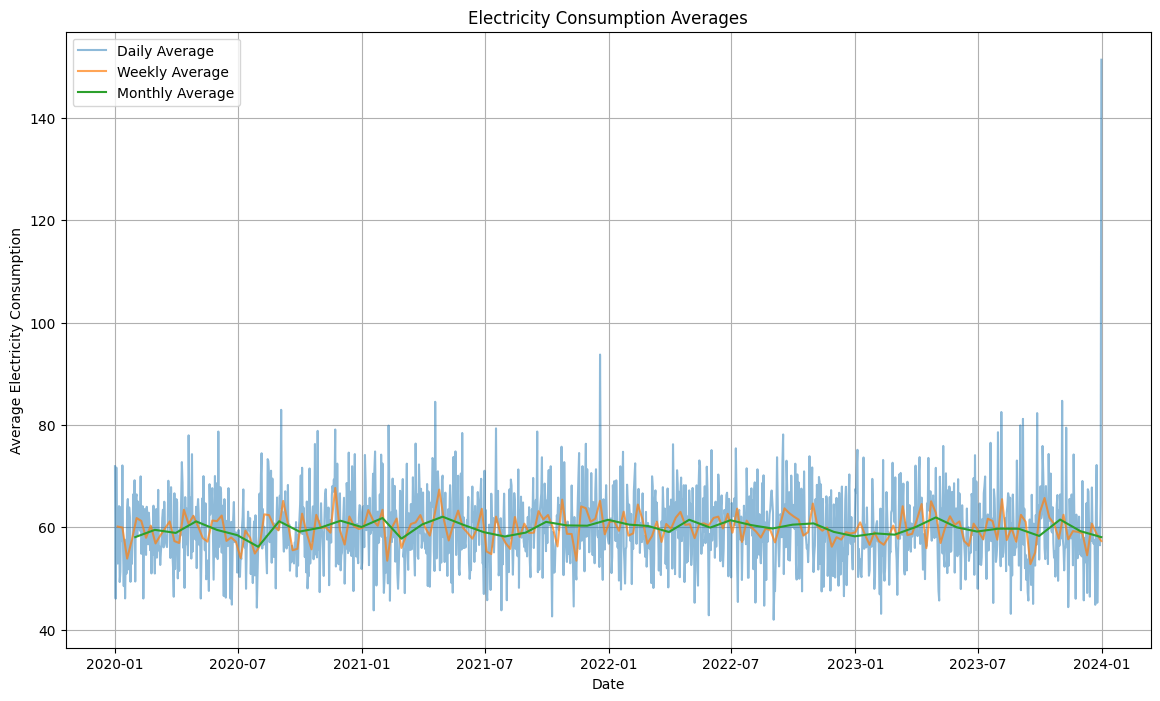

In [65]:
# Set up the plot with appropriate size and labels
plt.figure(figsize=(14, 8))
plt.plot(daily_data.index, daily_data['Electricity_Consumption'], label='Daily Average', alpha=0.5)
plt.plot(weekly_data.index, weekly_data['Electricity_Consumption'], label='Weekly Average', alpha=0.7)
plt.plot(monthly_data.index, monthly_data['Electricity_Consumption'], label='Monthly Average', alpha=1)

plt.title('Electricity Consumption Averages')
plt.xlabel('Date')
plt.ylabel('Average Electricity Consumption')
plt.legend()
plt.grid(True)

plt.show()


From this graph we see a general trend that can help us understand the overall trend of the daily average, weekly average, and monthly average.

The daily average follows the values well with high variability. 

The weekly average follows the trend better with some variability. 

The monthly average follows the trend best with little variability. 

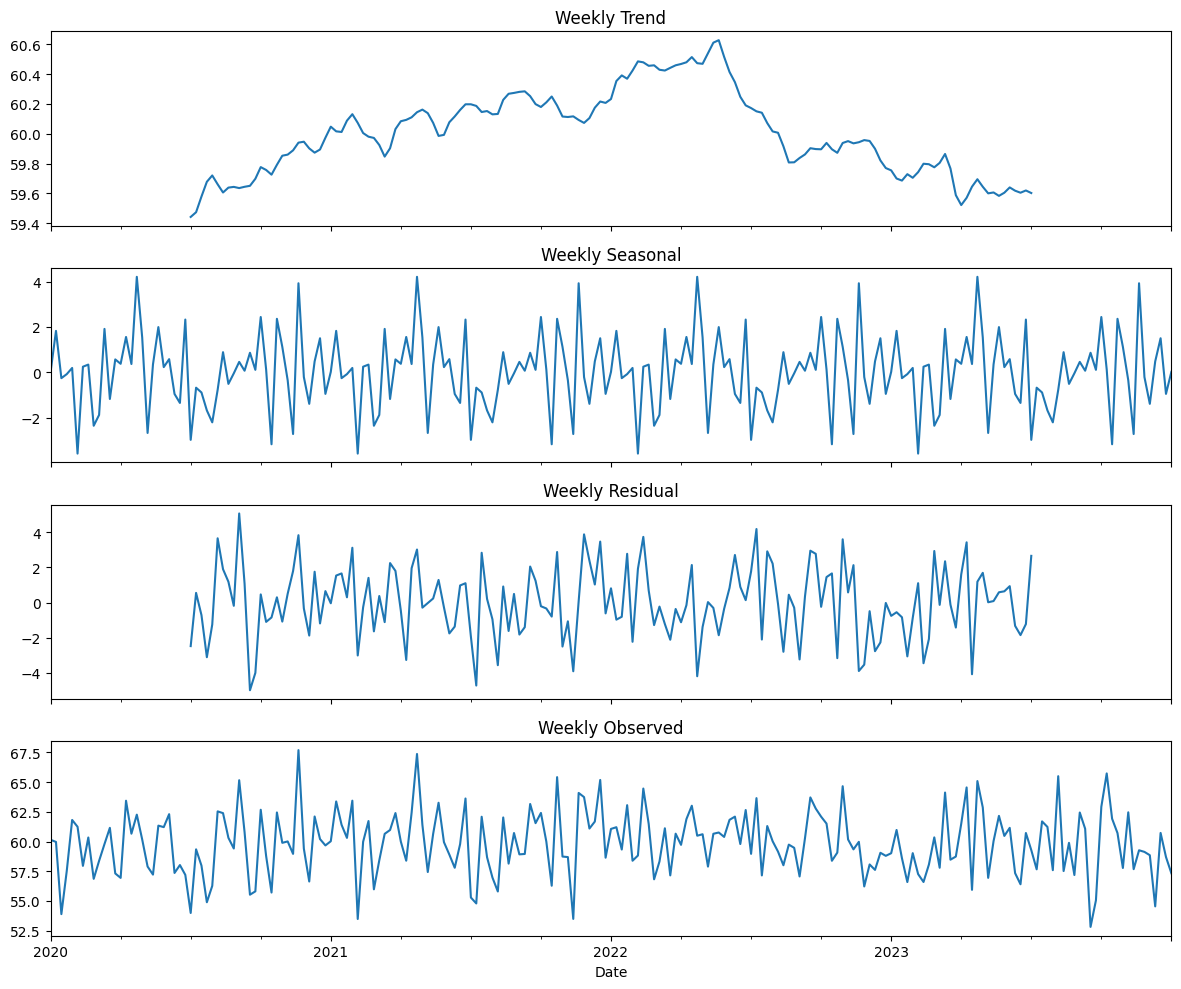

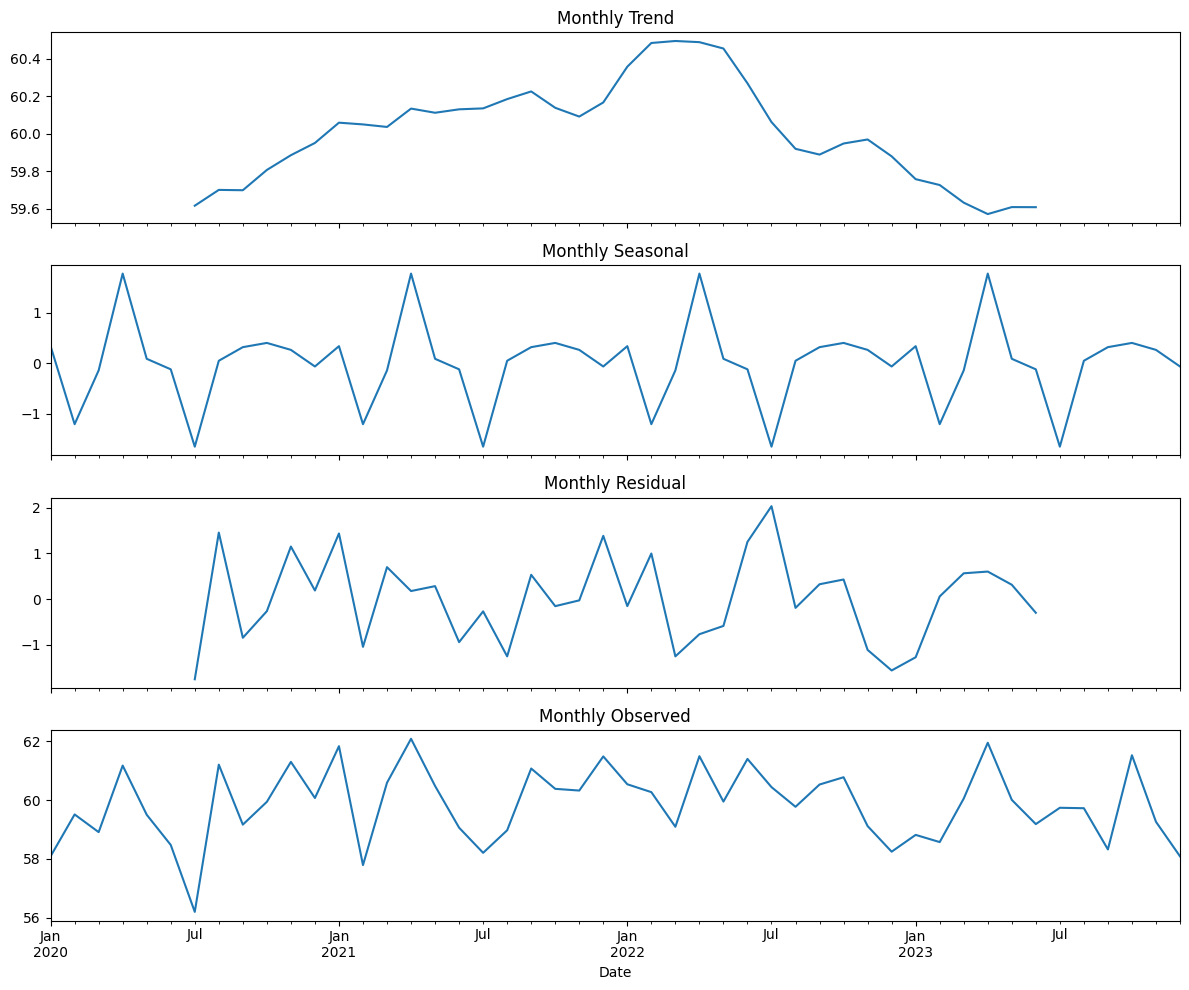

In [66]:
# Set the frequency of the data
weekly_data.index.freq = 'W'
monthly_data.index.freq = 'M'

# Decompose the weekly and monthly data
decomp_weekly = seasonal_decompose(weekly_data['Electricity_Consumption'], model='additive')
decomp_monthly = seasonal_decompose(monthly_data['Electricity_Consumption'], model='additive')

# Plotting the decompositions
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 10))
decomp_weekly.trend.plot(ax=axes[0], title='Weekly Trend')
decomp_weekly.seasonal.plot(ax=axes[1], title='Weekly Seasonal')
decomp_weekly.resid.plot(ax=axes[2], title='Weekly Residual')
decomp_weekly.observed.plot(ax=axes[3], title='Weekly Observed')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 10))
decomp_monthly.trend.plot(ax=axes[0], title='Monthly Trend')
decomp_monthly.seasonal.plot(ax=axes[1], title='Monthly Seasonal')
decomp_monthly.resid.plot(ax=axes[2], title='Monthly Residual')
decomp_monthly.observed.plot(ax=axes[3], title='Monthly Observed')
plt.tight_layout()
plt.show()


Here are the decomposition plots for both the weekly and monthly electricity consumption data:

Weekly Decomposition
- Trend Component: Shows the overall direction the data is moving over time.
- Seasonal Component: Represents the regular pattern in weekly intervals.
- Residual Component: Contains the noise or random variations that are not explained by the trend or seasonal components.
- Observed Component: The actual data plotted.

Monthly Decomposition
- Trend Component: Similar to the weekly, but smooths out over each month, providing a clearer view of longer-term movements.
- Seasonal Component: Shows seasonal fluctuations within the year.
- Residual Component: Displays the anomalies or leftover variations after accounting for the trend and seasonal patterns.
- Observed Component: The actual monthly data.

### Mean Absolute Error:

This value will give the average distance that the residuals are from the line of zero. The most accurate seasonal decomposition has residuals of 0, so the residual with the smallest mean absolute error is going to reflect a more accurate depiction of the movement of the data. Comparing the weekly and the monthly should also give better insight into which is better to use for the time interval. 

In [67]:
# Weekly MAE
weekly_mae = calculate_mae_with_zeroes(weekly_data['Electricity_Consumption'])
print("Weekly MAE:", weekly_mae)

Weekly MAE: 59.84879829292753


In [68]:
# Monthly MAE
monthly_mae = calculate_mae_with_zeroes(monthly_data['Electricity_Consumption'])
print("Monthly MAE:", monthly_mae)

Monthly MAE: 59.84679413247445


Based on how close these values are, we are going to look at the Mean Squared Error as well. 

In [69]:
# Weekly MSE
weekly_mse = calculate_mse_with_zeroes(weekly_data['Electricity_Consumption'])
print("Weekly MSE:", weekly_mse)

Weekly MSE: 3589.056287036629


In [70]:
# Monthly MSE
monthly_mse = calculate_mse_with_zeroes(monthly_data['Electricity_Consumption'])
print("Monthly MSE:", monthly_mse)

Monthly MSE: 3583.213802902741


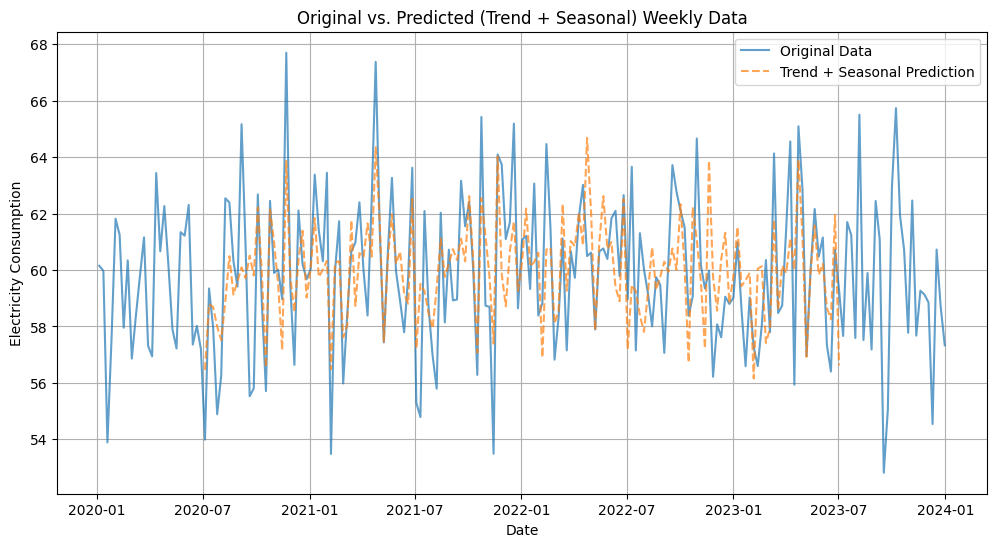

In [71]:
# Compute the prediction from the trend and seasonal components
weekly_predicted = decomp_weekly.trend + decomp_weekly.seasonal

# Plotting the original and predicted data
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data['Electricity_Consumption'], label='Original Data', alpha=0.7)
plt.plot(weekly_predicted.index, weekly_predicted, label='Trend + Seasonal Prediction', linestyle='--', alpha=0.7)
plt.title('Original vs. Predicted (Trend + Seasonal) Weekly Data')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid(True)
plt.show()


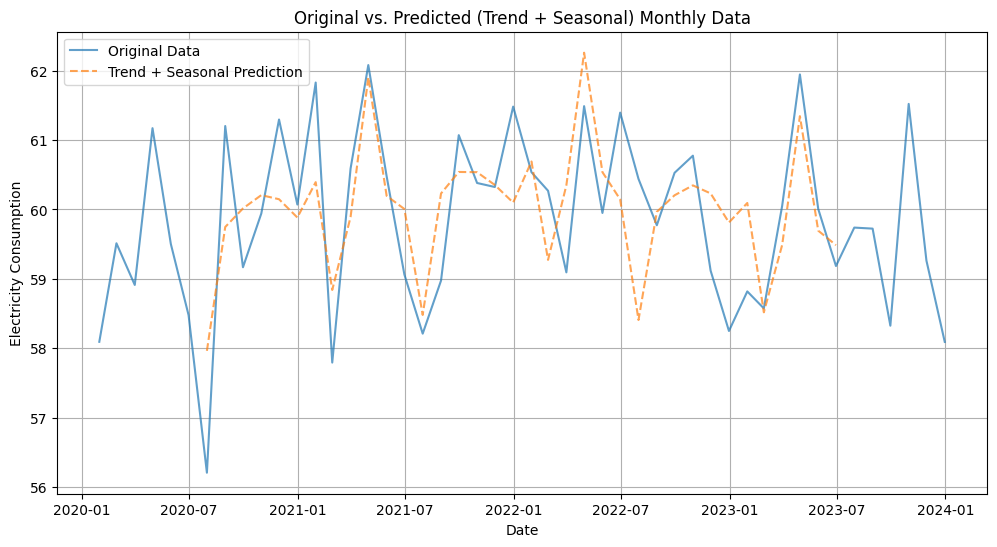

In [72]:
# Compute the prediction from the trend and seasonal components
monthly_predicted = decomp_monthly.trend + decomp_monthly.seasonal

# Plotting the original and predicted data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Electricity_Consumption'], label='Original Data', alpha=0.7)
plt.plot(monthly_predicted.index, monthly_predicted, label='Trend + Seasonal Prediction', linestyle='--', alpha=0.7)
plt.title('Original vs. Predicted (Trend + Seasonal) Monthly Data')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [181]:
weekly_electricity_consumption_decomposition = decompose_seasonality(daily_data['Electricity_Consumption'],7)

Based on the above MAE, MSE, and graphs without residual component, it appears that the weekly shows a better time interval of averages for the data to proceed for further analysis since it captures the variance well but is also smooth enough to show general trend. 

In [74]:
electricity_consumption = pd.read_csv('/Users/jonahzembower/Library/CloudStorage/OneDrive-SetonHillUniversity/Semester Classwork/Spring 2024 Semester SHU/Applied Statistics and Modeling/Projects/Final Project/electricity_consumption_data.csv')

In [75]:
# Rename the 'Date' column to 'day'
electricity_consumption.rename(columns={'Date': 'Hour'}, inplace=True)

# Convert 'day' to datetime type
electricity_consumption['Hour'] = pd.to_datetime(electricity_consumption['Hour'])

# Set 'day' as the index
electricity_consumption.set_index('Hour', inplace = True)

# Creating some future analysis
electricity_consumption['Incrementing Hour'] = range(1, len(electricity_consumption)+1)

# Show modified DataFrame
electricity_consumption

,Electricity_Consumption,Incrementing Hour
Hour,,
2020-01-01 00:00:00,134.183010,1
2020-01-01 01:00:00,67.498984,2
2020-01-01 02:00:00,140.533978,3
2020-01-01 03:00:00,27.359333,4
2020-01-01 04:00:00,50.032748,5
...,...,...
2023-12-30 20:00:00,109.420824,35037
2023-12-30 21:00:00,200.915641,35038
2023-12-30 22:00:00,45.851352,35039


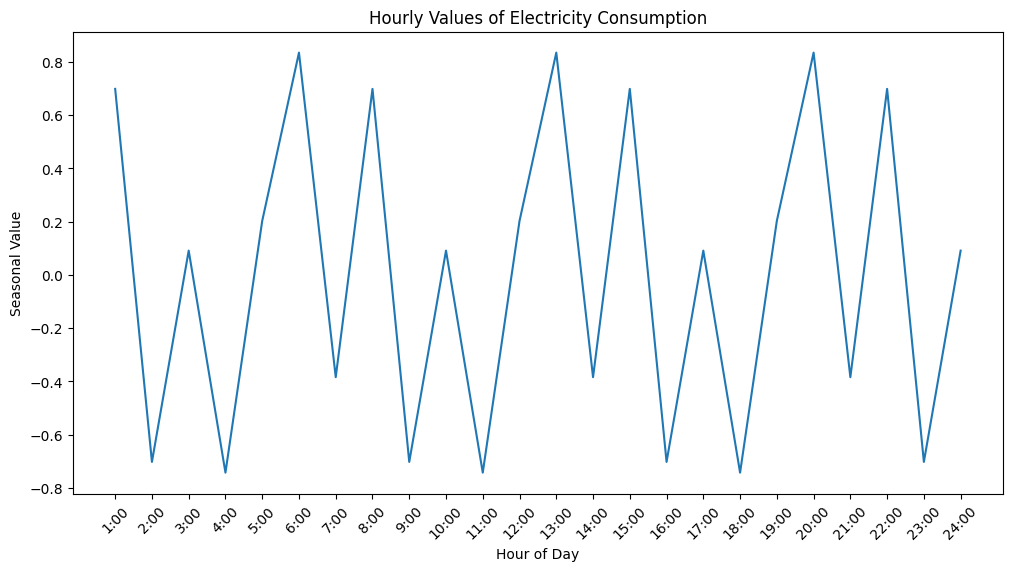

In [76]:
#plot the seasonal values on a graph so that you can understand which days have higher electricity consumed
hours_column=['1:00','2:00','3:00','4:00','5:00','6:00','7:00','8:00','9:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00','24:00']
seasonal_values_plot(weekly_electricity_consumption_decomposition[2],24,'seasonal',
                     'Hourly Values of Electricity Consumption','Hour of Day',hours_column,'Seasonal Value')

In [77]:
# Creating a dataframe for the hourly data that is into weeks
hourly_electricity_consumption = create_hourly_data(electricity_consumption,'Electricity_Consumption','Incrementing Hour')
hourly_electricity_consumption

,Hour 0,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,Hour 8,Hour 9,...,Hour 158,Hour 159,Hour 160,Hour 161,Hour 162,Hour 163,Hour 164,Hour 165,Hour 166,Hour 167
0,134.18301,67.498984,140.533978,27.359333,50.032748,67.898765,82.249851,57.406739,69.182943,64.9902,...,153.164963,33.77362,120.892596,25.961179,103.474206,35.337646,39.115146,169.513125,25.663972,56.589109
1,74.727951,41.322202,66.355238,49.566448,34.060347,20.547477,20.332783,79.35215,48.289601,49.084749,...,83.297052,46.556939,69.242396,73.118494,68.995863,65.667165,66.702652,39.407891,46.563445,17.031476
2,68.15691,19.332312,36.290062,57.183133,41.884055,75.638117,88.25468,60.983161,64.839362,78.617523,...,70.291417,19.068577,148.816255,29.964666,17.166749,18.421034,33.981412,66.260417,59.793466,38.047884
3,23.24397,30.841602,19.40905,22.465539,91.580408,65.706061,48.497724,21.168755,106.808132,54.821026,...,95.730625,44.793583,99.104992,47.866257,38.349857,112.965035,94.904669,10.916087,75.00433,29.08785
4,11.483118,24.112123,22.690557,87.135684,29.490827,72.84816,67.672553,59.833632,87.569036,81.854157,...,22.888184,68.146321,79.101631,54.978293,197.520505,47.040109,26.91035,32.628668,36.91414,70.440091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,85.87051,53.078085,34.604294,75.078634,117.559356,60.194472,33.567648,43.529703,50.734871,45.223949,...,24.722798,24.750591,32.762642,41.702943,9.153328,55.073261,30.898815,52.376183,50.888489,71.905046
205,108.866209,18.013949,76.00787,68.858814,110.626804,64.61114,56.430094,48.454462,121.310892,34.798507,...,55.312485,41.084119,116.377179,39.827678,50.151079,167.961867,71.489646,57.125348,62.094431,104.040971
206,53.468064,37.770121,79.761719,37.989584,33.04421,60.810265,10.61854,82.51314,74.911241,75.529369,...,14.01211,39.257506,32.106333,69.440757,80.03438,98.928791,58.027541,16.841386,74.442947,27.047671
207,63.733215,17.273645,51.741121,46.618065,32.923188,56.22243,19.862339,55.374263,73.070286,19.253988,...,45.95195,127.915583,36.590375,22.312271,55.569503,84.807889,48.213902,33.979506,30.365486,12.086493


Drop the last row to remove the NaN values. 

In [78]:
# Drop the last row of the dataframe for hourly_electricity_consumption
hourly_electricity_consumption = hourly_electricity_consumption.drop(hourly_electricity_consumption.index[208])
hourly_electricity_consumption

,Hour 0,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,Hour 8,Hour 9,...,Hour 158,Hour 159,Hour 160,Hour 161,Hour 162,Hour 163,Hour 164,Hour 165,Hour 166,Hour 167
0,134.18301,67.498984,140.533978,27.359333,50.032748,67.898765,82.249851,57.406739,69.182943,64.9902,...,153.164963,33.77362,120.892596,25.961179,103.474206,35.337646,39.115146,169.513125,25.663972,56.589109
1,74.727951,41.322202,66.355238,49.566448,34.060347,20.547477,20.332783,79.35215,48.289601,49.084749,...,83.297052,46.556939,69.242396,73.118494,68.995863,65.667165,66.702652,39.407891,46.563445,17.031476
2,68.15691,19.332312,36.290062,57.183133,41.884055,75.638117,88.25468,60.983161,64.839362,78.617523,...,70.291417,19.068577,148.816255,29.964666,17.166749,18.421034,33.981412,66.260417,59.793466,38.047884
3,23.24397,30.841602,19.40905,22.465539,91.580408,65.706061,48.497724,21.168755,106.808132,54.821026,...,95.730625,44.793583,99.104992,47.866257,38.349857,112.965035,94.904669,10.916087,75.00433,29.08785
4,11.483118,24.112123,22.690557,87.135684,29.490827,72.84816,67.672553,59.833632,87.569036,81.854157,...,22.888184,68.146321,79.101631,54.978293,197.520505,47.040109,26.91035,32.628668,36.91414,70.440091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,57.464727,29.084972,76.341726,114.116295,75.916648,109.628903,17.036346,34.952453,55.868293,44.17826,...,101.399418,30.991373,83.267001,31.297906,7.38244,39.587184,16.352821,68.343986,50.762207,56.383376
204,85.87051,53.078085,34.604294,75.078634,117.559356,60.194472,33.567648,43.529703,50.734871,45.223949,...,24.722798,24.750591,32.762642,41.702943,9.153328,55.073261,30.898815,52.376183,50.888489,71.905046
205,108.866209,18.013949,76.00787,68.858814,110.626804,64.61114,56.430094,48.454462,121.310892,34.798507,...,55.312485,41.084119,116.377179,39.827678,50.151079,167.961867,71.489646,57.125348,62.094431,104.040971
206,53.468064,37.770121,79.761719,37.989584,33.04421,60.810265,10.61854,82.51314,74.911241,75.529369,...,14.01211,39.257506,32.106333,69.440757,80.03438,98.928791,58.027541,16.841386,74.442947,27.047671


In [79]:
hourly_electricity_consumption_statisitcs = create_hourly_statistics(electricity_consumption, 'Electricity_Consumption', 'Incrementing Hour')
hourly_electricity_consumption_statisitcs

,mean,median,std,variance
Hour 0,60.040833,57.424799,32.476675,1054.734422
Hour 1,56.630707,49.563939,35.392657,1252.640194
Hour 2,58.913389,52.442092,33.481759,1121.028216
Hour 3,56.657291,51.234139,30.361253,921.805687
Hour 4,61.518291,54.24248,34.569038,1195.018375
...,...,...,...,...
Hour 163,60.318025,54.144463,32.059687,1027.823551
Hour 164,58.984124,51.506997,32.338467,1045.776477
Hour 165,58.003509,55.319675,31.568697,996.582637
Hour 166,64.315351,56.812231,34.456921,1187.279422


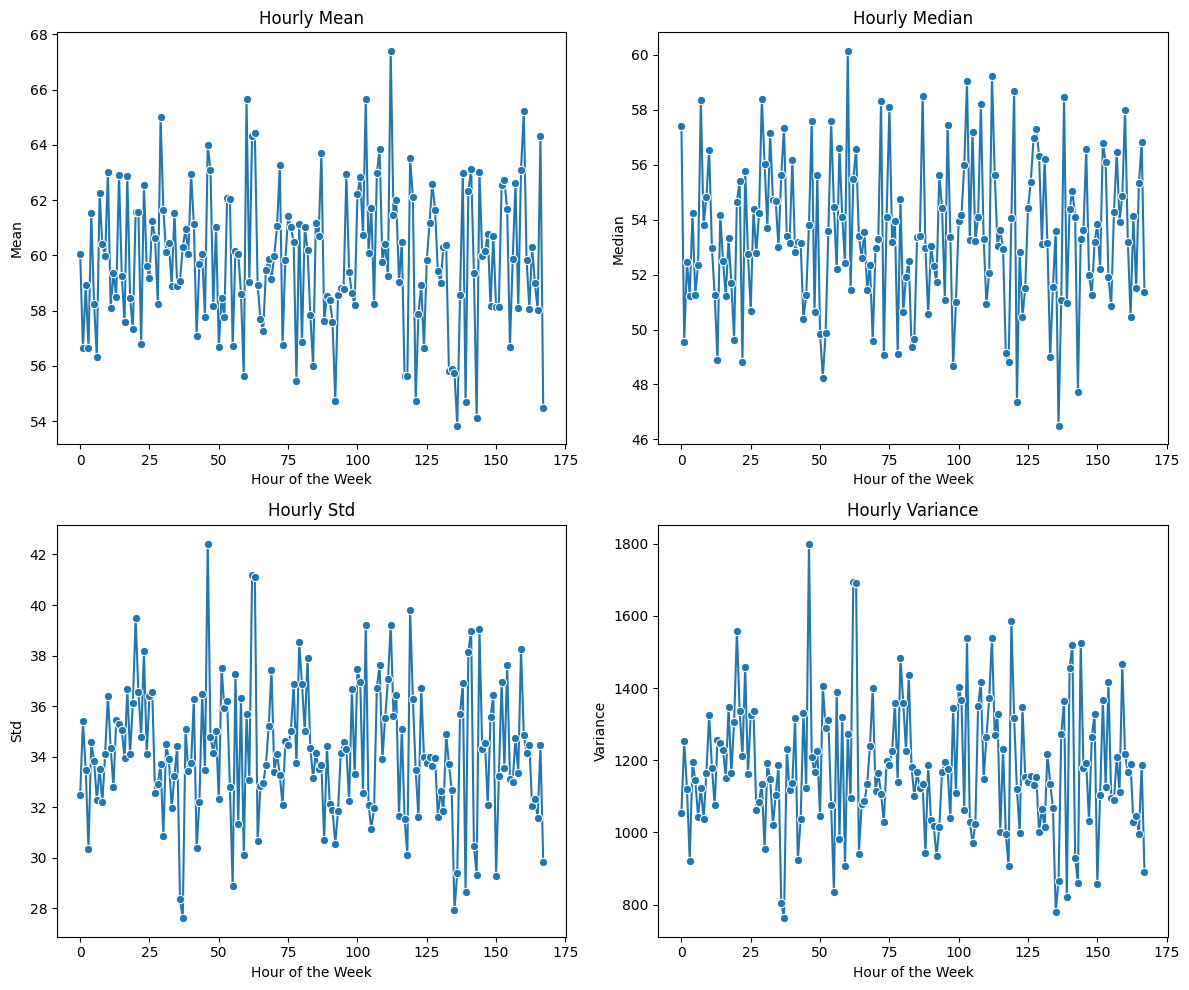

In [80]:
import seaborn as sns
# Plot the statistics
plt.figure(figsize=(12, 10))
for i, stat in enumerate(['mean', 'median', 'std', 'variance'], 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=hourly_electricity_consumption_statisitcs, y=stat, x=np.arange(168), marker='o', linestyle='-')
    plt.title(f'Hourly {stat.capitalize()}')
    plt.xlabel('Hour of the Week')
    plt.ylabel(stat.capitalize())
plt.tight_layout()
plt.show()

### ARIMA Model Building:

##### q order for electricity consumption

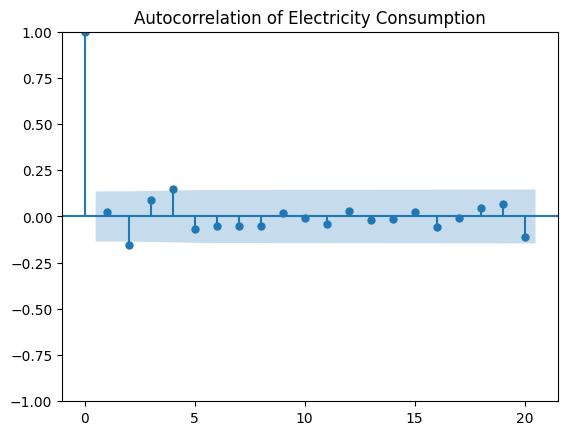

In [183]:
#Plot the ACF values
acf_values_electricity_consumption = plot_acf(weekly_data['Electricity_Consumption'],lags=20,title='Autocorrelation of Electricity Consumption')

In [164]:
# Potential MA (q) order
q_orders_electricity_consumption = [2,3,4,20]

#### p Order for Electricity Consumption

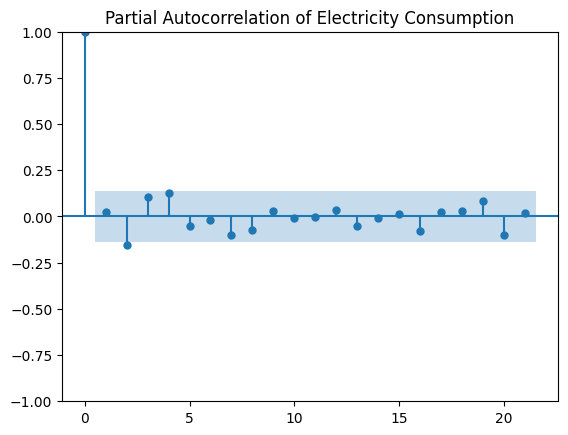

In [165]:
#Plot the PACF values
pacf_values_electricity_consumption = plot_pacf(weekly_data['Electricity_Consumption'],lags=21,title='Partial Autocorrelation of Electricity Consumption')

In [166]:
# Potential AR(p) order
p_orders_electricity_consumption = [2,3,4,7]

#### d Order for Electricity Consumption

In [85]:
# Determine the stationarity of electricity consumption
adf_test(electricity_consumption['Electricity_Consumption'])

ADF Statistic:  -187.70413120519996
P-Value:  0.0
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


- ADF Statistic: This is the test statistic for the ADF test. If the ADF statistic is more negative than the critical values, it suggests that we can reject the null hypothesis (which is that the time series possesses a unit root and is non-stationary).
- P-Value: This indicates the probability of observing the test statistic if the null hypothesis is true. A lower p-value (commonly below 0.05) suggests that the null hypothesis can be rejected. In your case, a p-value of 0.0 suggests that the time series does not have a unit root and is stationary.
- Critical Values: These are the test statistic values at which the null hypothesis for stationarity can be rejected with a certain level of confidence. Your critical values for the 1%, 5%, and 10% levels suggest that if your ADF statistic is below -3.43, -2.86, and -2.57 respectively, you can reject the null hypothesis with 99%, 95%, and 90% confidence, respectively.


In [86]:
# d order for stationarity
d_orders_electricity_consumption = [0,1]

Looking at ARIMA models:

In [168]:
warnings.filterwarnings("ignore")
# Looking at the best AR, MA, And d components for ARIMA model
model_arima = evaluate_time_series_models(weekly_data['Electricity_Consumption'], p_orders_electricity_consumption, q_orders_electricity_consumption, d_orders_electricity_consumption)
model_arima.head()

,Model,Order,AIC,BIC
6,MA,"(0, 0, 4)",1005.498847,1025.552853
2,AR,"(4, 0, 0)",1006.261793,1026.315798
25,ARIMA,"(2, 0, 3)",1007.563119,1030.959459
9,ARMA,"(2, 0, 3)",1007.563119,1030.959459
32,ARIMA,"(3, 0, 2)",1007.643052,1031.039392


#### Removing Seasonality for P,D,Q:

In [185]:
# Create the series for sunpots that has removed the seasonality values from the original values
weekly_electricity_consumption_seasonal_removed = weekly_electricity_consumption_decomposition[0] - weekly_electricity_consumption_decomposition [2]
weekly_electricity_consumption_seasonal_removed

Date
2020-01-01     72.222622
2020-01-02     45.415560
2020-01-03     71.810092
2020-01-04     58.818564
2020-01-05     51.846616
                 ...    
2023-12-27     56.998358
2023-12-28     59.411948
2023-12-29     56.611818
2023-12-30     65.508195
2023-12-31    150.324803
Freq: D, Length: 1461, dtype: float64

#### Q order for electricity consumption

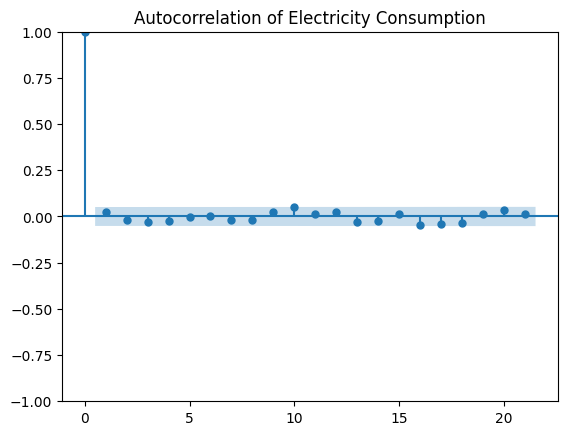

In [186]:
#Plot the new acf 
acf_values_electricity_consumption_seasonally_adjusted = plot_acf(weekly_electricity_consumption_seasonal_removed,lags=21, title='Autocorrelation of Electricity Consumption')

In [90]:
# Orders for Q
Q_orders_electricity_consumption = [1,2,3,4,5]

#### P order for electricity consumption

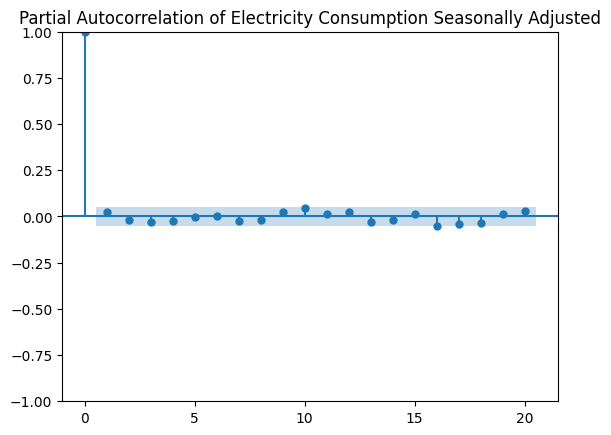

In [187]:
#Plot the PACF values
pacf_values_electricity_consumption_seasonally_adjusted = plot_pacf(weekly_electricity_consumption_seasonal_removed,lags=20,
                                                                    title='Partial Autocorrelation of Electricity Consumption Seasonally Adjusted')

In [92]:
# Orders for P
P_orders_electricity_consumption = [1,2,3,4,5]

#### D order for electricity consumption

In [93]:
adf_test(weekly_electricity_consumption_seasonal_removed)

ADF Statistic:  -187.67645000066213
P-Value:  0.0
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [96]:
#D order
D_orders_electricity_consumption = [0,1]

Looking at SARIMA models:

In [178]:
warnings.filterwarnings("ignore")
# Going through all combinations to find the best sarima model based on AIC and BIC
select_best_sarima_model(daily_data['Electricity_Consumption'], p_orders_electricity_consumption, d_orders_electricity_consumption, q_orders_electricity_consumption, P_orders_electricity_consumption, D_orders_electricity_consumption, Q_orders_electricity_consumption, 7)

{'aic': 10036.91381866593,
 'bic': 10047.487571489432,
 'pdq': (0, 0, 0),
 'seasonal_pdq': (0, 0, 0, 7)}

#### Best Model Selection:
MA = (0,0,4)
- AIC: 1005.498847
- BIC: 1025.552853

SARIMA = (0,0,0) (0,0,0,7)
- AIC: 10036.91381866593
- BIC: 10047.487571489432,

I will now use the MA model (0,0,4) to forecast values of electricity consumption.

### Forecasting:

Looking at the forecast against current data:

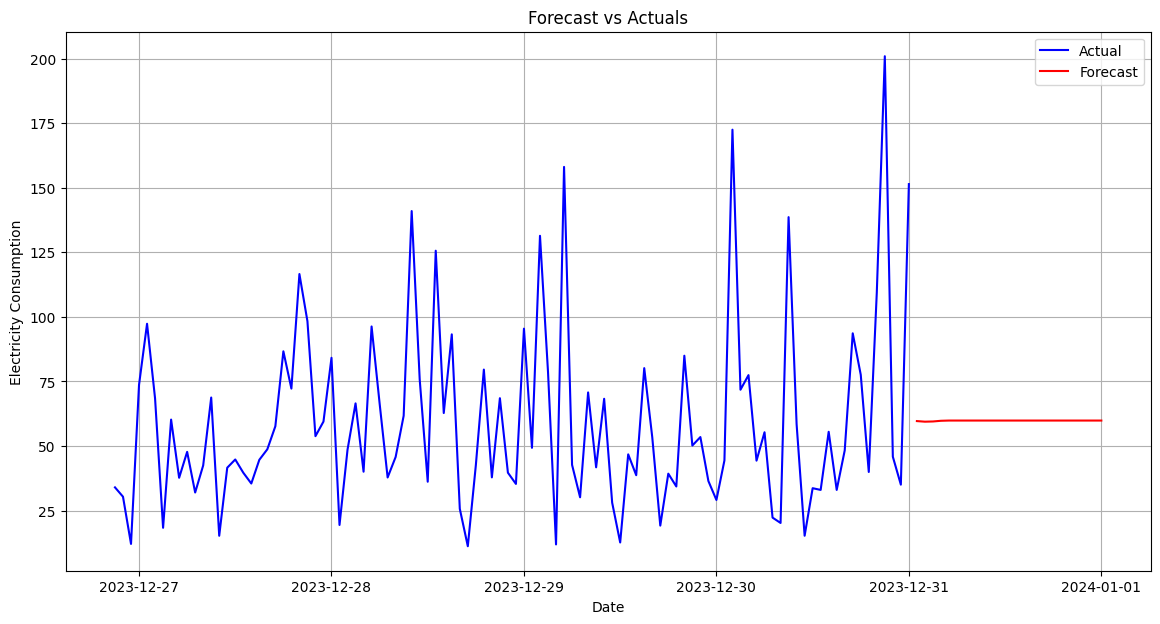

In [177]:
# Fitting the MA(4) model
model = ARIMA(electricity_consumption['Electricity_Consumption'], order=(0,0,4))
model_fit = model.fit()

# Forecast the next 24 hours
forecast_horizon = 24
forecast_result = model_fit.get_forecast(steps=forecast_horizon)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
# Correct the date range for the forecast to start right after the last known data point
forecast_dates = pd.date_range(start=electricity_consumption.index[-1] + pd.Timedelta(hours=1), periods=forecast_horizon, freq='H')

plt.figure(figsize=(14, 7))
plt.plot(electricity_consumption.index[-100:], electricity_consumption['Electricity_Consumption'].tail(100), label='Actual', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')

# If using confidence intervals
# plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid(True)
plt.show()



### Model Evaluation:

In [176]:
# Calculating MSE and RMSE for the actual vs. predicted values
# Compute in-sample predictions
in_sample_preds = model_fit.predict(start=electricity_consumption.index[0], end=electricity_consumption.index[-1])

# Calculate MAE and RMSE
mae = mean_absolute_error(electricity_consumption['Electricity_Consumption'], in_sample_preds)
rmse = np.sqrt(mean_squared_error(electricity_consumption['Electricity_Consumption'], in_sample_preds))

mae, rmse


(26.58284639496824, 34.31137091991085)

Discussion on Model's Limitations:
- Model Complexity: The MA(4) model is relatively simple and primarily captures the average movement in the data based on recent error terms. It might not effectively account for more complex patterns such as seasonality, trends, or cycles, which are likely present in electricity consumption data.
- In-sample Focus: The metrics evaluated are based on in-sample predictions. This might not provide a full understanding of how the model would perform on unseen future data.
- Lack of External Factors: Electricity consumption can be influenced by numerous external factors such as weather conditions, holidays, and economic activities, which are not considered in a simple MA model.

# Sunspots

In [98]:
# Read the sunspots dataset
sunspots.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


This dataset contains historical records of sunspots. Typical sunspot datasets include measurements such as the date of observation, sunspot numbers, and sometimes details about solar cycles. Such data is crucial for studying solar activity and its cycles over time.

#### Data Preprocessing:

In [99]:
# Rename the 'Date' column to 'day'
sunspots.rename(columns={'Date': 'Month'}, inplace=True)

# Convert 'day' to datetime type
sunspots['Month'] = pd.to_datetime(sunspots['Month'])

# Set 'day' as the index
sunspots.set_index('Month', inplace=True)

# Drop the unnamed index column
sunspots.drop(columns=['Unnamed: 0'], inplace=True)

# Creating some future analysis
sunspots['Incrementing Month'] = range(1, len(sunspots)+1)

# Show the modified DataFrame
sunspots.head()


,Monthly Mean Total Sunspot Number,Incrementing Month
Month,,
1749-01-31,96.7,1
1749-02-28,104.3,2
1749-03-31,116.7,3
1749-04-30,92.8,4
1749-05-31,141.7,5


In [100]:
#Create a new data frame that has monthly data
#This is going to make it easier to draw statistics from the data based on its seasonality
sunspots_monthly=create_monthly_data(sunspots,'Monthly Mean Total Sunspot Number','Incrementing Month')
sunspots_monthly

,January,February,March,April,May,June,July,August,September,October,November,December
0,96.7,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0
1,122.2,126.5,148.7,147.2,150.0,166.7,142.3,171.7,152.0,109.5,105.5,125.7
2,116.7,72.5,75.5,94.0,101.2,84.5,110.5,99.7,39.2,38.7,47.5,73.3
3,58.3,83.3,118.3,98.8,99.5,66.0,130.7,48.8,45.2,77.7,62.7,66.7
4,73.3,53.3,76.2,63.3,60.0,52.8,36.7,65.0,46.7,41.7,33.3,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...
268,26.1,26.4,17.7,32.3,18.9,19.2,17.8,32.6,43.7,13.2,5.7,8.2
269,6.8,10.7,2.5,8.9,13.1,15.6,1.6,8.7,3.3,4.9,4.9,3.1
270,7.7,0.8,9.4,9.1,9.9,1.2,0.9,0.5,1.1,0.4,0.5,1.5
271,6.2,0.2,1.5,5.2,0.2,5.8,6.1,7.5,0.6,14.4,34.0,21.8


I am dropping the last row since it only has one value for January.

In [101]:
# Drop the last row of the dataframe for sunspots_monthly
sunspots_monthly = sunspots_monthly.drop(sunspots_monthly.index[272])
sunspots_monthly

,January,February,March,April,May,June,July,August,September,October,November,December
0,96.7,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0
1,122.2,126.5,148.7,147.2,150.0,166.7,142.3,171.7,152.0,109.5,105.5,125.7
2,116.7,72.5,75.5,94.0,101.2,84.5,110.5,99.7,39.2,38.7,47.5,73.3
3,58.3,83.3,118.3,98.8,99.5,66.0,130.7,48.8,45.2,77.7,62.7,66.7
4,73.3,53.3,76.2,63.3,60.0,52.8,36.7,65.0,46.7,41.7,33.3,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...
267,57.0,56.4,54.1,37.9,51.5,20.5,32.4,50.2,44.6,33.4,21.4,18.5
268,26.1,26.4,17.7,32.3,18.9,19.2,17.8,32.6,43.7,13.2,5.7,8.2
269,6.8,10.7,2.5,8.9,13.1,15.6,1.6,8.7,3.3,4.9,4.9,3.1
270,7.7,0.8,9.4,9.1,9.9,1.2,0.9,0.5,1.1,0.4,0.5,1.5


### Exploratory Data Analysis:

In [102]:
# Getting general statistics for the sunspots_monthly dataframe
sunspots_statistics = mean_median_variance_std_monthly(sunspots_monthly,columns=['January','February','March','April','May','June','July','August','September','October','November','December'])
sunspots_statistics

,January,February,March,April,May,June,July,August,September,October,November,December,Monthly Mean,Monthly Median,Standard Deviation,Variance
0,96.7,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0,231.214286,126.15,45.368273,2058.280227
1,122.2,126.5,148.7,147.2,150.0,166.7,142.3,171.7,152.0,109.5,105.5,125.7,238.285714,144.75,21.120176,446.061818
2,116.7,72.5,75.5,94.0,101.2,84.5,110.5,99.7,39.2,38.7,47.5,73.3,136.185714,80.00,26.756731,715.922652
3,58.3,83.3,118.3,98.8,99.5,66.0,130.7,48.8,45.2,77.7,62.7,66.7,136.571429,72.20,27.158569,737.587879
4,73.3,53.3,76.2,63.3,60.0,52.8,36.7,65.0,46.7,41.7,33.3,11.2,87.642857,53.05,18.527038,343.251136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,6.2,0.2,1.5,5.2,0.2,5.8,6.1,7.5,0.6,14.4,34.0,21.8,14.785714,5.95,10.185473,103.743864
Mean,78.581618,81.625368,80.205515,81.161397,83.135662,82.440441,82.323529,83.419485,82.863235,82.756985,81.087132,82.007353,NaN,NaN,NaN,NaN
Median,65.0,71.8,75.0,68.3,68.0,66.5,68.6,66.7,66.0,72.5,66.3,65.9,NaN,NaN,NaN,NaN
Variance,4482.31947,4415.41817,4025.035898,4310.399841,4749.224309,4524.745368,4636.930466,4915.901786,4979.102942,4623.523987,4521.71299,4889.287125,NaN,NaN,NaN,NaN


This gives us the general statistics that can be found from the monthly data. 

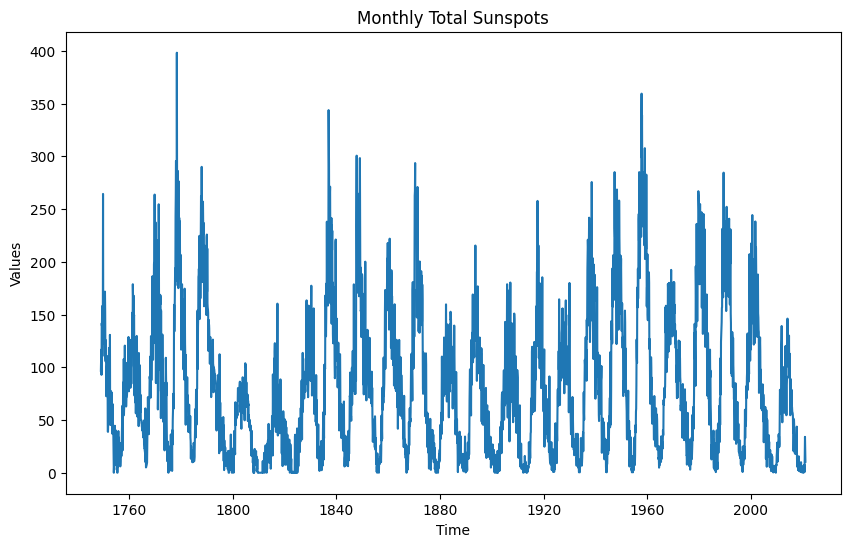

In [103]:
#Plot the time series
time_series(sunspots.index,sunspots['Monthly Mean Total Sunspot Number'],'Monthly Total Sunspots','Time','Values')

In [104]:
#Monthly electricity consumption decomposition
monthly_sunspots_decomposition = decompose_seasonality(sunspots['Monthly Mean Total Sunspot Number'],12)

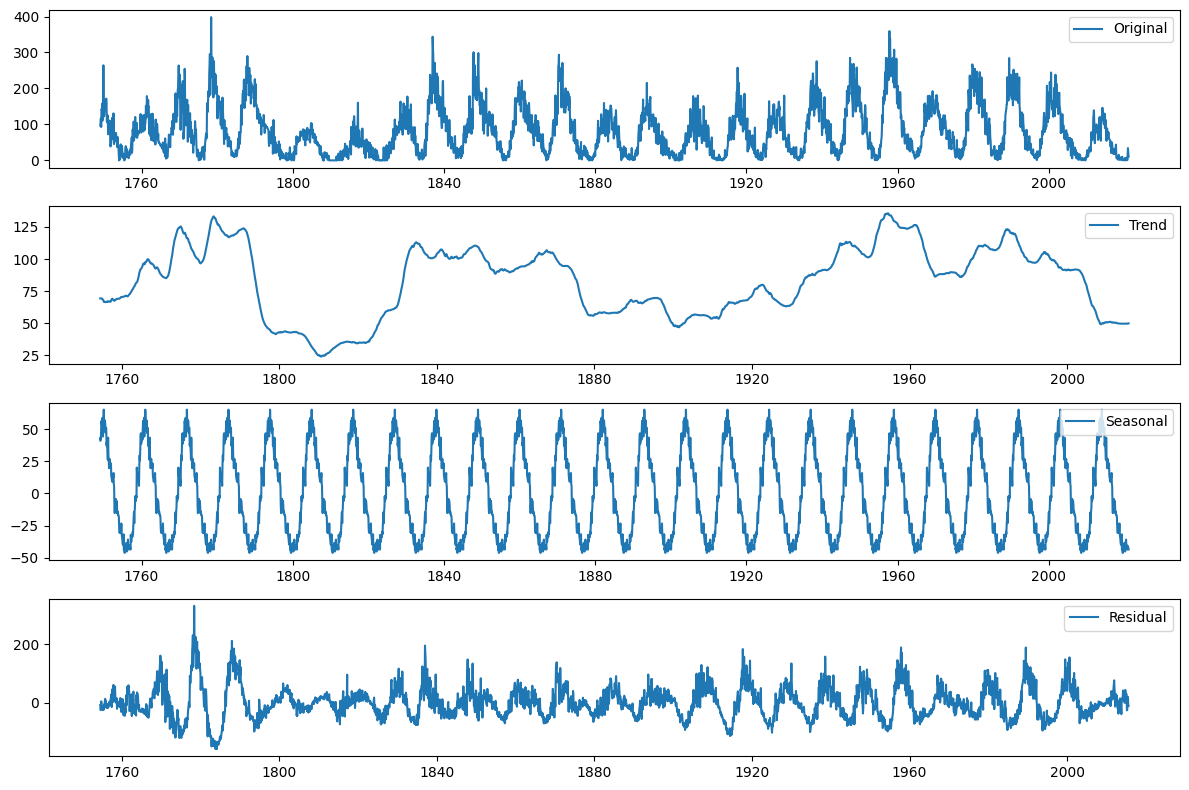

In [105]:
#Plot the electricity consumption which has a lag of 12 which would represent the months of the year
plot_seasonal_decomposition(sunspots['Monthly Mean Total Sunspot Number'],132)

There is clear seasonality over the period of 11 years that shows a visual pattern that has an up and down relationship. However, it also shows that the trend is potentially stationary. 

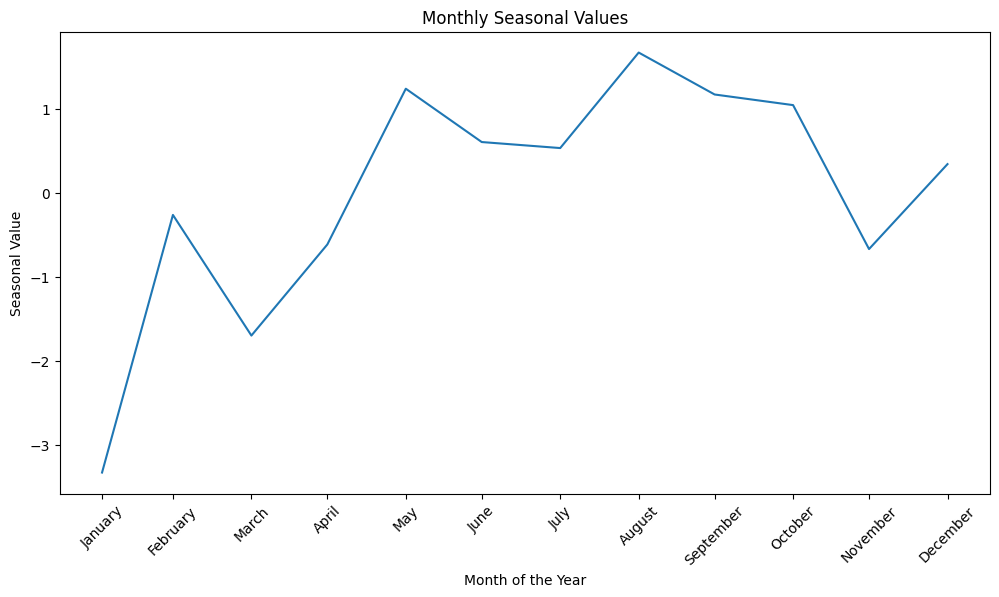

In [106]:
months_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
#Plot the seasonal monthly values graph
seasonal_values_plot(monthly_sunspots_decomposition[2],12,'seasonal',
                     'Monthly Seasonal Values','Month of the Year',months_list,'Seasonal Value')

This shows an interesteing trend for the seasonal values in one year, but there is still a clear period of 11 years overall.

In [107]:
monthly_data = sunspots.resample('M').mean()
# Monthly MAE for sunspots
monthly_mae = calculate_mae_with_zeroes(monthly_data['Monthly Mean Total Sunspot Number'])
print("Monthly MAE:", monthly_mae)

Monthly MAE: 81.77877488514548


We are choosing monthly for the time interval, but it is still high as seen here. I already chose to do monthly, but I wanted to look more at the individual periods for each year.

Now I will look at the monthly mean for sunspots.

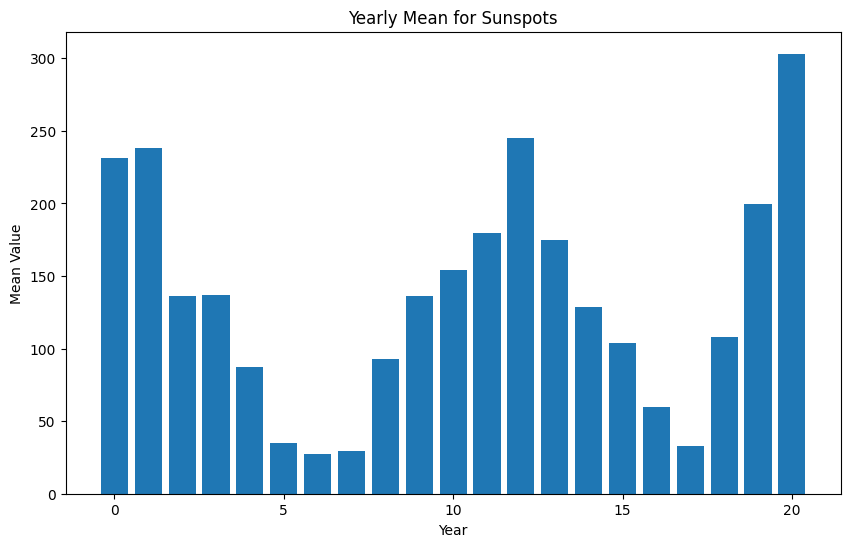

In [108]:
# Create a bar chart of the mean of the values of each month
bar_chart(sunspots_statistics.index[0:21],sunspots_statistics['Monthly Mean'][0:21],'Yearly Mean for Sunspots','Year','Mean Value')

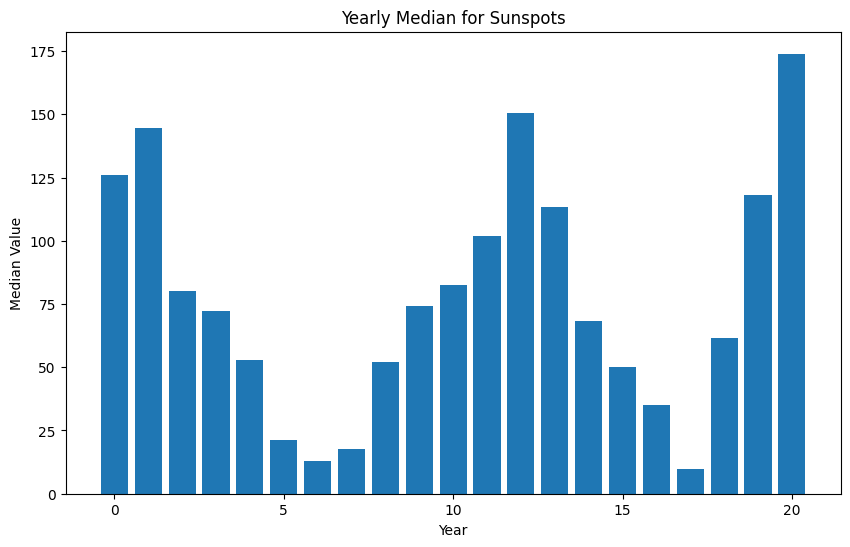

In [109]:
# Create a bar chart of the median of the values of each month
bar_chart(sunspots_statistics.index[0:21],sunspots_statistics['Monthly Median'][0:21],'Yearly Median for Sunspots','Year','Median Value')

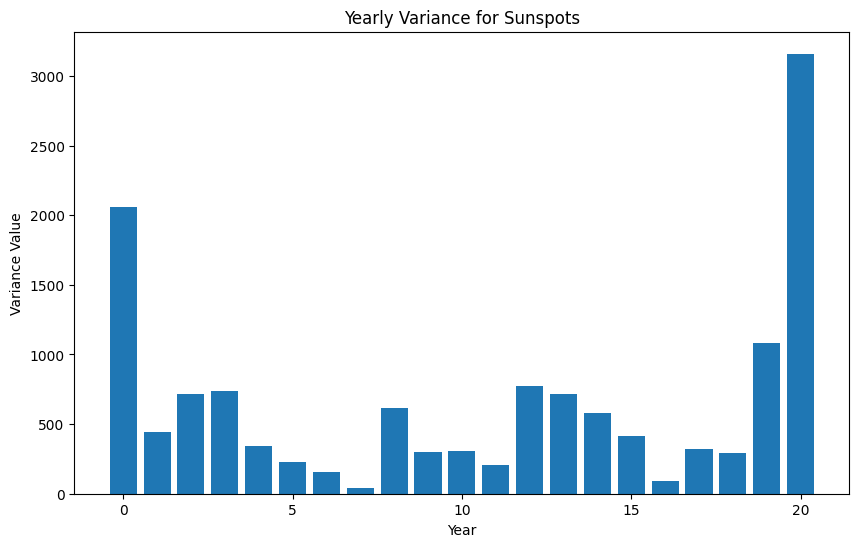

In [110]:
# Create a bar chart of the mean of the values of each month
bar_chart(sunspots_statistics.index[0:21],sunspots_statistics['Variance'][0:21],'Yearly Variance for Sunspots','Year','Variance Value')

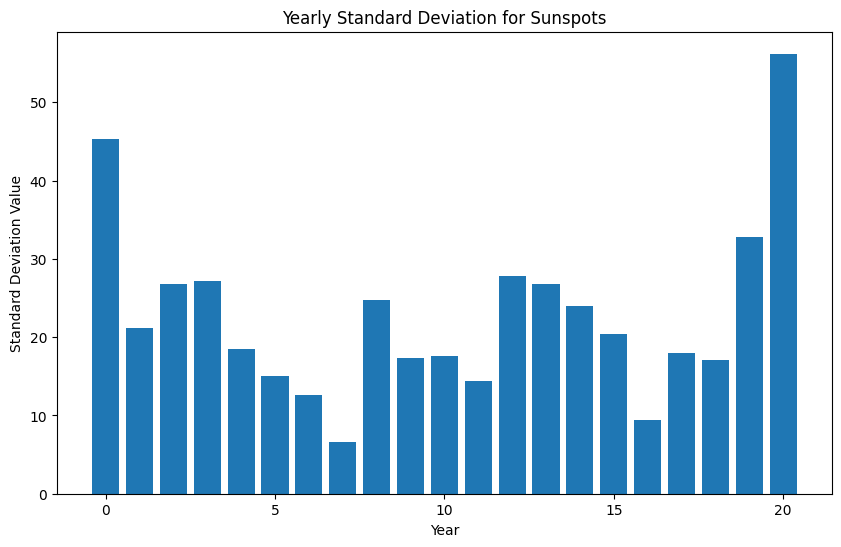

In [111]:
# Create a bar chart of the mean of the values of each month
bar_chart(sunspots_statistics.index[0:21],sunspots_statistics['Standard Deviation'][0:21],'Yearly Standard Deviation for Sunspots','Year','Standard Deviation Value')

### ARIMA Model Building:

#### q order for Sunspots

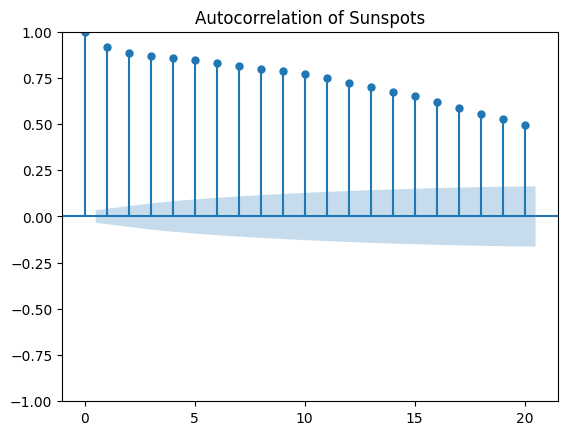

In [112]:
#Plot the ACF values
acf_values_sunspots = plot_acf(sunspots['Monthly Mean Total Sunspot Number'],lags=20,title='Autocorrelation of Sunspots')

In [113]:
# MA (q) order
q_orders_sunspots = [1,2,3,4,5]

#### p order for sunspots

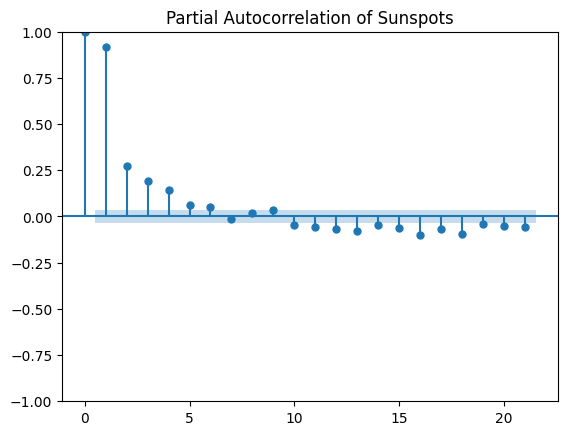

In [114]:
#Plot the PACF values
pacf_values_sunspots = plot_pacf(sunspots['Monthly Mean Total Sunspot Number'],lags=21,title='Partial Autocorrelation of Sunspots')

In [115]:
# AR (p) order
p_orders_sunspots = [1,2,3,4,16]

#### d order for sunspots

In [116]:
# Determine the stationarity of sunspots
adf_test(sunspots['Monthly Mean Total Sunspot Number'])

ADF Statistic:  -10.497051662546134
P-Value:  1.108552492195682e-18
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


1. ADF Statistic: -10.497051662546134
- This value is the result of the ADF test. A more negative value suggests stronger evidence against the null hypothesis that the time series has a unit root (i.e., is non-stationary).
2. P-Value: 1.108552492195682e-18
- The p-value indicates the probability of observing the ADF statistic or something more extreme under the null hypothesis. A very small p-value (typically < 0.05) leads us to reject the null hypothesis, indicating that the time series does not have a unit root and is stationary.
3. Critical Values:
- These values are thresholds that the ADF statistic must cross to reject the null hypothesis at different significance levels:
  - 1%: -3.43
  - 5%: -2.86
  - 10%: -2.57

In [117]:
# Order for d
d_orders_sunspots = [0,1]

No need to remove seasonality since the time series is already appearing to be stationary. 

We will now progress with the following ARIMA model. 

In [118]:
warnings.filterwarnings("ignore")
# Looking at the best AR, MA, And d components for ARIMA models
model_arima = evaluate_time_series_models(sunspots['Monthly Mean Total Sunspot Number'], p_orders_sunspots, q_orders_sunspots, d_orders_sunspots)
model_arima.head()

,Model,Order,AIC,BIC
30,ARMA,"(16, 0, 1)",30154.431603,30270.160889
75,ARIMA,"(16, 0, 1)",30154.431603,30270.160889
33,ARMA,"(16, 0, 4)",30157.139439,30291.141770
78,ARIMA,"(16, 0, 4)",30157.139439,30291.141770
76,ARIMA,"(16, 0, 2)",30160.292521,30282.112822


Based on these findings, it appears together that we should choose ARIMA(16,0,1)

#### Removing Seasonality from data for P,D,Q

In [119]:
# Create the series for sunpots that has removed the seasonality values from the original values
monthly_sunspots_seasonal_removed = monthly_sunspots_decomposition[0] - monthly_sunspots_decomposition [2]
monthly_sunspots_seasonal_removed

Month
1749-01-31    100.031411
1749-02-28    104.565282
1749-03-31    118.400937
1749-04-30     93.416850
1749-05-31    140.463206
                 ...    
2020-09-30     -0.568082
2020-10-31     13.358302
2020-11-30     34.671417
2020-12-31     21.460516
2021-01-31     13.731411
Length: 3265, dtype: float64

#### Q order for Sunspots

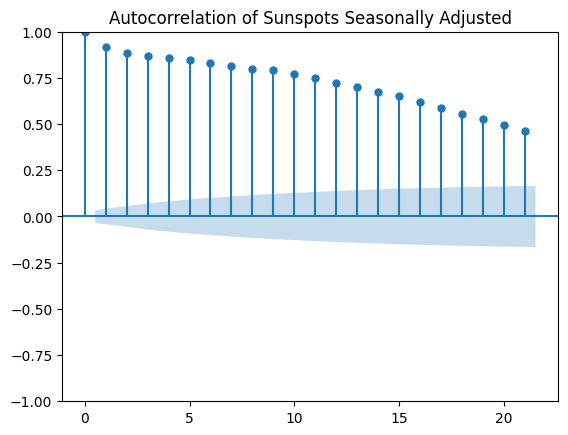

In [120]:
#Plot the new acf 
acf_values_sunspots_seasonally_adjusted = plot_acf(monthly_sunspots_seasonal_removed,lags=21, title='Autocorrelation of Sunspots Seasonally Adjusted')

In [121]:
# Orders for Q
Q_orders_sunspots = [1,2,3,4,5]

#### P order for sunspots

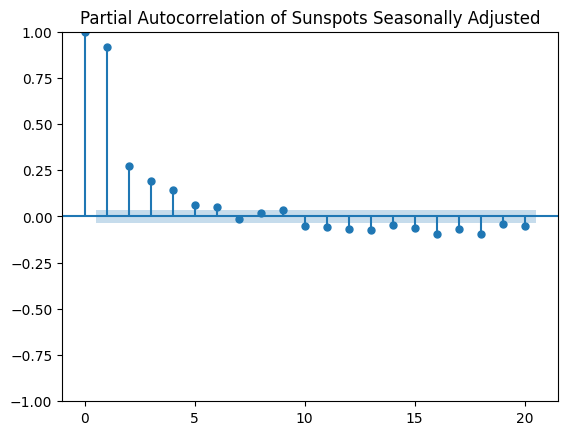

In [122]:
#Plot the PACF values
pacf_values_sunspots_seasonally_adjusted = plot_pacf(monthly_sunspots_seasonal_removed,lags=20,
                                                                    title='Partial Autocorrelation of Sunspots Seasonally Adjusted')

In [123]:
# Orders for P
P_orders_sunspots = [1,2,3,4,16]

#### D order for sunspots

In [124]:
adf_test(monthly_sunspots_seasonal_removed)

ADF Statistic:  -10.485828851931194
P-Value:  1.1811270625174262e-18
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [125]:
# Orders for D
D_orders_sunspots = [0,1]

We will now look at the following SARIMA models

In [126]:
warnings.filterwarnings("ignore")
# Going through all combinations to find the best sarima model based on AIC and BIC
select_best_sarima_model(sunspots['Monthly Mean Total Sunspot Number'], p_orders_sunspots, d_orders_sunspots, q_orders_sunspots, P_orders_sunspots, D_orders_sunspots, Q_orders_sunspots, 12)

{'aic': 30181.10394832894,
 'bic': 30229.83206866262,
 'pdq': (3, 0, 2),
 'seasonal_pdq': (0, 0, 1, 12)}

#### Best Model Selection:
ARIMA = (16,0,1) 
- AIC: 30154.431603
- BIC: 30270.160889

SARIMA = (3,0,2) (0,0,1,12)
- AIC: 30181.10394832894
- BIC: 30229.83206866262

We will use the SARIMA model then to forecast the future data points. 

### Forecasting:

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81721D+00    |proj g|=  5.30120D-01


 This problem is unconstrained.



At iterate    5    f=  4.65618D+00    |proj g|=  9.16353D-03

At iterate   10    f=  4.65581D+00    |proj g|=  4.24003D-03

At iterate   15    f=  4.65517D+00    |proj g|=  1.24856D-02

At iterate   20    f=  4.65487D+00    |proj g|=  4.21291D-04

At iterate   25    f=  4.65476D+00    |proj g|=  5.85045D-03

At iterate   30    f=  4.65152D+00    |proj g|=  5.65575D-02

At iterate   35    f=  4.64516D+00    |proj g|=  1.10500D-02

At iterate   40    f=  4.64375D+00    |proj g|=  8.51976D-03

At iterate   45    f=  4.64250D+00    |proj g|=  2.60730D-03

At iterate   50    f=  4.64215D+00    |proj g|=  9.17174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

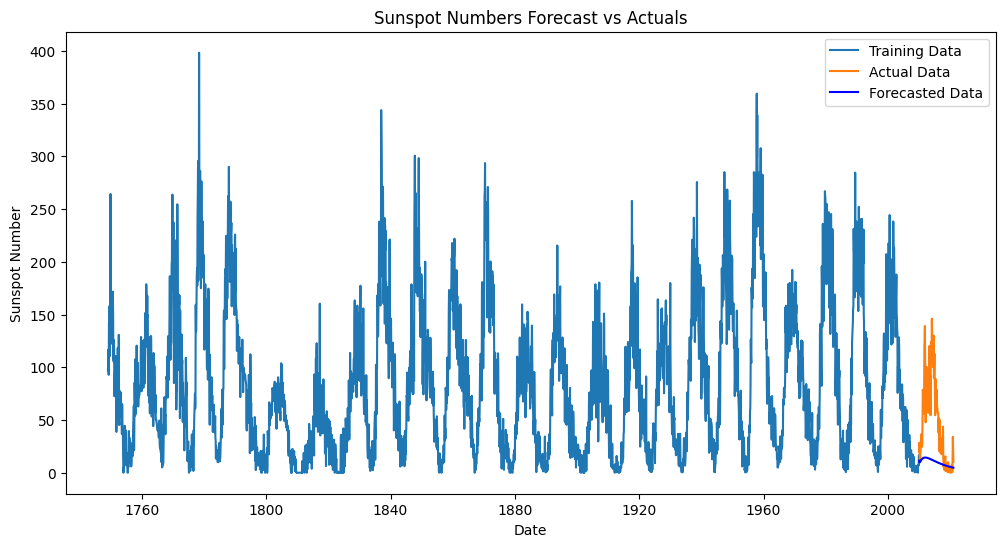

In [190]:
# Define the training and testing dataset
split_date = '2010-01-01'
train = sunspots[sunspots.index < pd.to_datetime(split_date)]
test = sunspots[sunspots.index >= pd.to_datetime(split_date)]


model = SARIMAX(train['Monthly Mean Total Sunspot Number'], order=(3,0,2), seasonal_order=(0,0,1,12))
results = model.fit()

# Making predictions
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Monthly Mean Total Sunspot Number'], label='Training Data')
plt.plot(test.index, test['Monthly Mean Total Sunspot Number'], label='Actual Data')
plt.plot(test.index, predictions, label='Forecasted Data', color='blue')
plt.title('Sunspot Numbers Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()


### Model Evaluation:

In [193]:
# Convert test DataFrame to Series to match the predictions Series
test_series = test.iloc[:, 0]

# Calculate error metrics again
mae = mean_absolute_error(test_series, predictions)
rmse = np.sqrt(mean_squared_error(test_series, predictions))

mae, rmse


(40.803346673201254, 55.19363834896935)

Model Limitations and Discrepancies:
- Convergence Issue: The model did not converge, which suggests that the optimization algorithm did not find a solution within the allowed number of iterations. This can impact the accuracy of the model.
- Seasonality and Trend Representation: The model parameters may not be optimally capturing the complex seasonality and trends in the data. Adjustments to the model parameters or a different approach might be needed to improve accuracy.
- Model Complexity: With a SARIMA(3,0,2)(0,0,1,12), the model attempts to balance between capturing the trend and seasonal effects. However, the lack of seasonal differencing (D=0) might be inadequate for data with strong seasonal patterns.

# Website Traffic

In [127]:
website_traffic

,Date,Daily_Visitors
0,2020-01-01,202
1,2020-01-02,204
2,2020-01-03,197
3,2020-01-04,197
4,2020-01-05,239
...,...,...
1456,2023-12-27,185
1457,2023-12-28,202
1458,2023-12-29,234
1459,2023-12-30,194


This dataset records data related to website traffic.

In [128]:
# To check for any potential null values
website_traffic.isnull().sum()

Date              0
Daily_Visitors    0
dtype: int64

### Data Preprocessing:

In [129]:
# Rename the 'Date' column to 'day'
website_traffic.rename(columns={'Date': 'Day'}, inplace=True)

# Convert 'day' to datetime type
website_traffic['Day'] = pd.to_datetime(website_traffic['Day'])

# Set 'day' as the index
website_traffic.set_index('Day', inplace = True)

# Creating some future analysis
website_traffic['Incrementing Day'] = range(1, len(website_traffic)+1)

# Show modified DataFrame
website_traffic

,Daily_Visitors,Incrementing Day
Day,,
2020-01-01,202,1
2020-01-02,204,2
2020-01-03,197,3
2020-01-04,197,4
2020-01-05,239,5
...,...,...
2023-12-27,185,1457
2023-12-28,202,1458
2023-12-29,234,1459


### Exploratory Data Analysis:

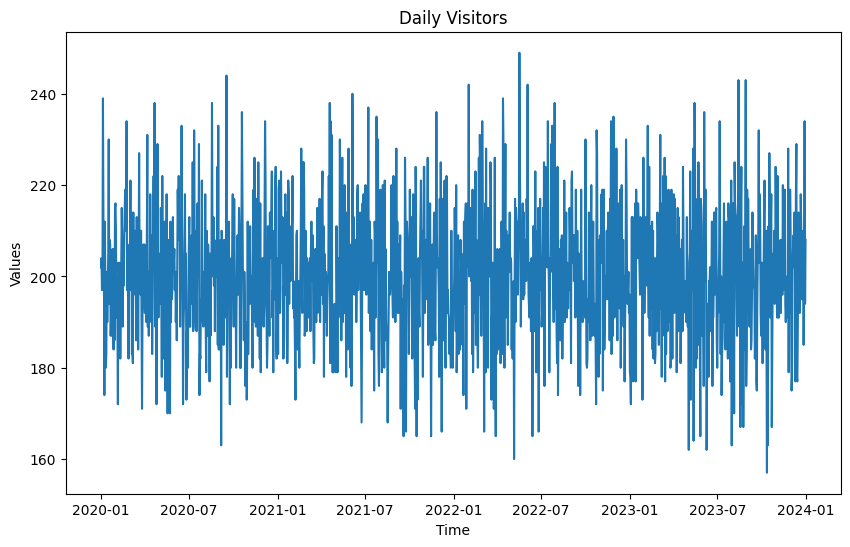

In [130]:
# Plot the time series
time_series(website_traffic.index,website_traffic['Daily_Visitors'],'Daily Visitors','Time','Values')

I chose to do weekly for the decomposition because it is daily data, and it makes sense to look at the weekly understanding for website_traffic.

In [131]:
#Create a new dataframe that is in weekly data
#This is done so that you can look at the different statistical information easier
#You can look at these statistics based on their week and also on their day of the week
website_traffic_weekly = create_weekly_data(website_traffic,'Daily_Visitors','Incrementing Day')
website_traffic_weekly

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,202,204,197,197,239,213,203
1,174,212,198,180,183,201,190
2,198,205,230,194,208,207,187
3,192,203,187,206,199,184,206
4,186,215,216,210,191,191,192
...,...,...,...,...,...,...,...
204,219,210,195,175,178,202,206
205,209,202,214,202,177,218,229
206,178,177,189,214,200,200,192
207,197,218,211,199,195,203,210


Now I will replace the missing values that are NaN.

In [132]:
#Find the average from weeks 1-208 and then replace na with those values
days_replace = ['Saturday','Sunday']
missing_values_replace(days_replace,website_traffic_weekly,0,208)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,202,204,197,197,239,213,203
1,174,212,198,180,183,201,190
2,198,205,230,194,208,207,187
3,192,203,187,206,199,184,206
4,186,215,216,210,191,191,192
...,...,...,...,...,...,...,...
204,219,210,195,175,178,202,206
205,209,202,214,202,177,218,229
206,178,177,189,214,200,200,192
207,197,218,211,199,195,203,210


Finding mean, standard deviation, median, and variance.

In [133]:
#Create mean, median, std and variance for days of week and each week
website_traffic_statistics = mean_median_variance_std_weekly(website_traffic_weekly,['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
website_traffic_statistics

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekly Mean,Weekly Median,Standard Deviation,Variance
0,202,204,197,197,239,213,203,207.857143,203.0,14.747074,217.476190
1,174,212,198,180,183,201,190,191.142857,190.0,13.322019,177.476190
2,198,205,230,194,208,207,187,204.142857,205.0,13.704361,187.809524
3,192,203,187,206,199,184,206,196.714286,199.0,9.086882,82.571429
4,186,215,216,210,191,191,192,200.142857,192.0,12.928374,167.142857
...,...,...,...,...,...,...,...,...,...,...,...
208,185,202,234,194,208,202.653846,201.177885,203.833104,202.0,15.223783,231.763581
Mean,199.435407,199.511962,198.555024,200.248804,200.497608,202.653846,201.177885,NaN,NaN,NaN,NaN
Median,199.0,200.0,197.0,201.0,199.5,202.0,201.0,NaN,NaN,NaN,NaN
Variance,187.816984,202.916463,225.342971,198.131542,234.348759,211.388107,214.830713,NaN,NaN,NaN,NaN


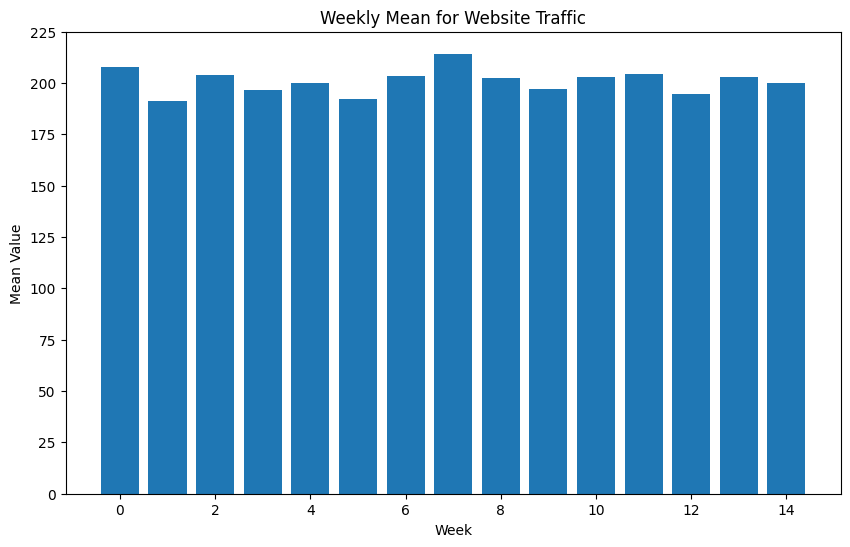

In [134]:
#Create a bar chart of the mean of the values of weeks 1-15
bar_chart(website_traffic_statistics.index[0:15],website_traffic_statistics['Weekly Mean'][0:15],'Weekly Mean for Website Traffic','Week','Mean Value')

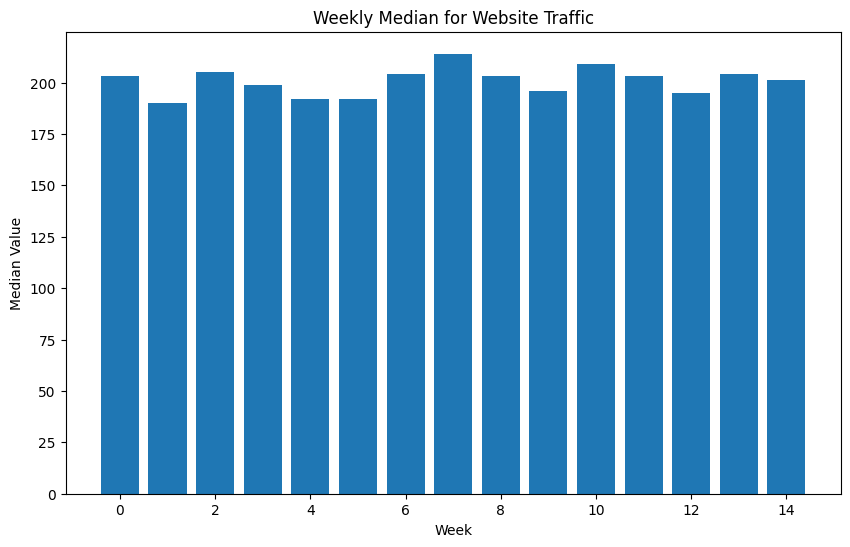

In [135]:
#Create a bar chart of the weekly median of weeks 1-15
bar_chart(website_traffic_statistics.index[0:15],website_traffic_statistics['Weekly Median'][0:15],'Weekly Median for Website Traffic','Week','Median Value')

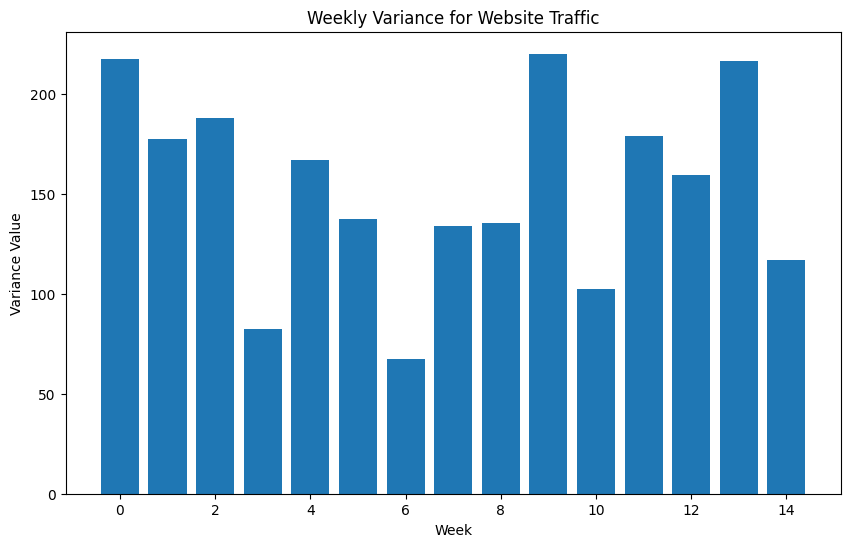

In [136]:
#Plot the bar chart for variance of the values (daily values) from weeks 1-15
bar_chart(website_traffic_statistics.index[0:15],website_traffic_statistics['Variance'][0:15],'Weekly Variance for Website Traffic','Week','Variance Value')

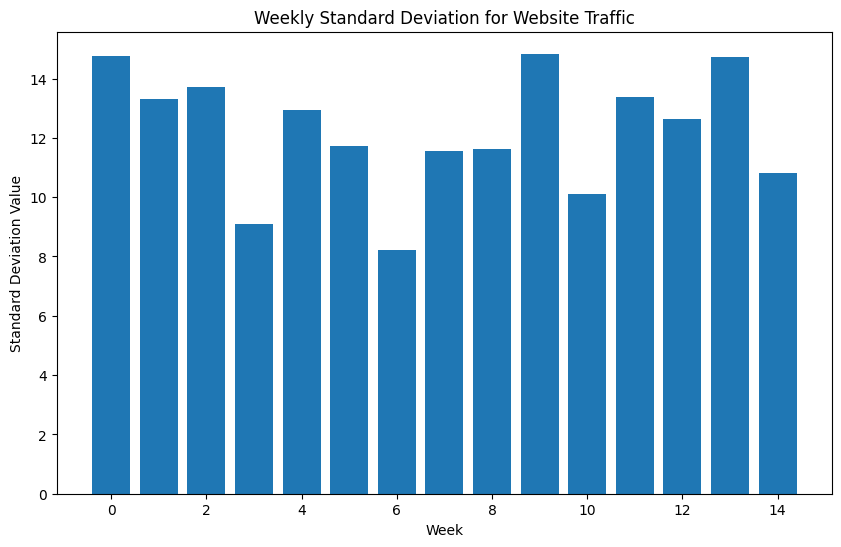

In [137]:
#Plot the standard deviation of the values (daily values) from weeks 1-15
bar_chart(website_traffic_statistics.index[0:15],website_traffic_statistics['Standard Deviation'][0:15],'Weekly Standard Deviation for Website Traffic','Week','Standard Deviation Value')

In [138]:
#Monthly electricity consumption decomposition
weekly_website_traffic_decomposition = decompose_seasonality(website_traffic['Daily_Visitors'],7)

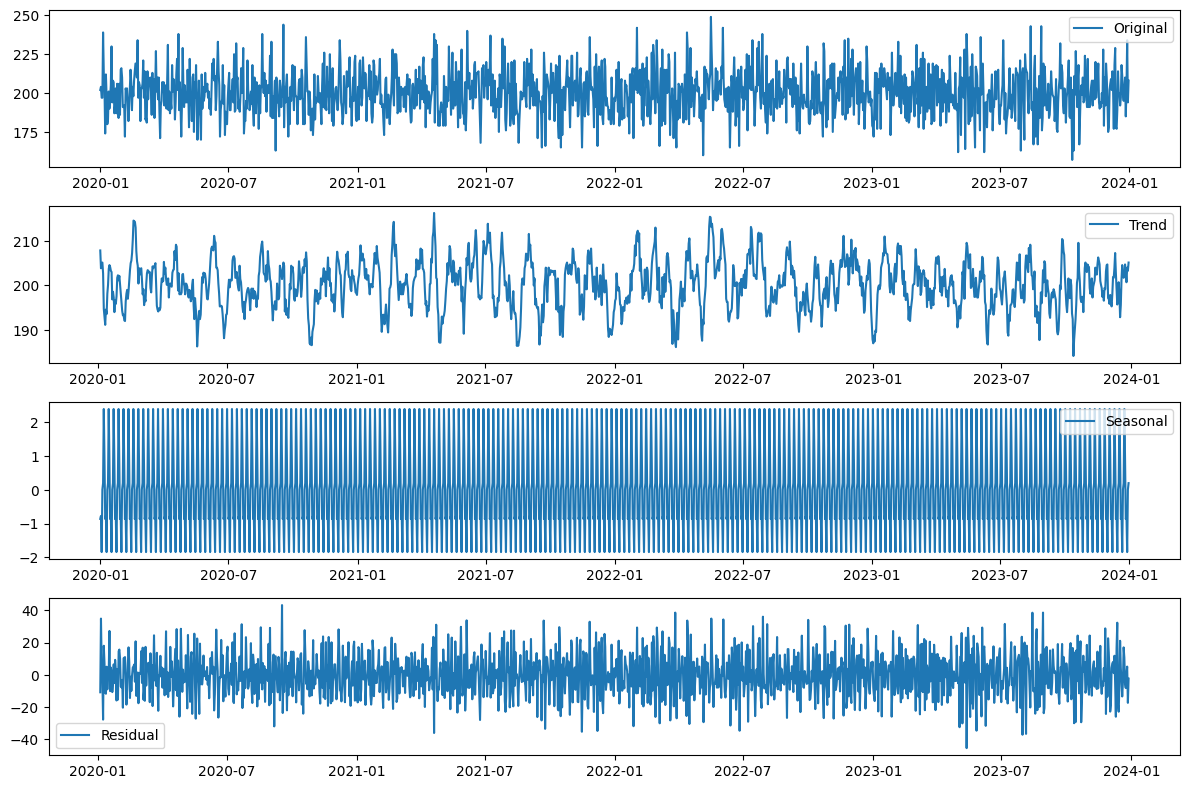

In [139]:
# Looking at the decomposition of website_traffic
plot_seasonal_decomposition(website_traffic['Daily_Visitors'],7)

1. Trend: This graph shows the long-term progression of the data, highlighting increases or decreases over the years.
2. Seasonality: This indicates regular patterns that repeat over time, showing monthly fluctuations in visitor numbers.
3. Residual: These are the irregularities that remain after the trend and seasonal components are removed, representing the randomness or noise in the data.

### ARIMA Model Building:

#### q order for website traffic

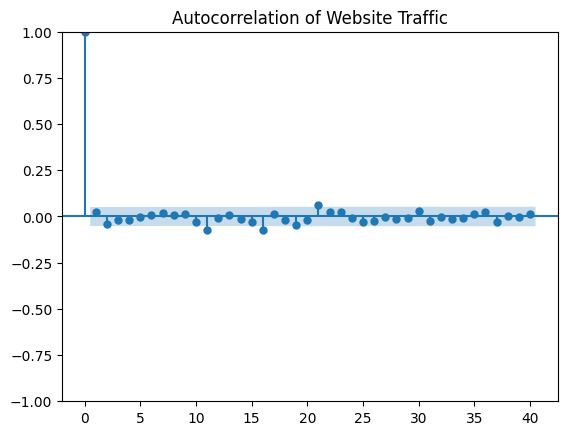

In [140]:
#Plot the ACF values
acf_values_website_traffic = plot_acf(website_traffic['Daily_Visitors'],lags=40,title='Autocorrelation of Website Traffic')

In [141]:
# MA (q) orders
q_orders_website_traffic = [1,6,12,24]

#### p order for website traffic

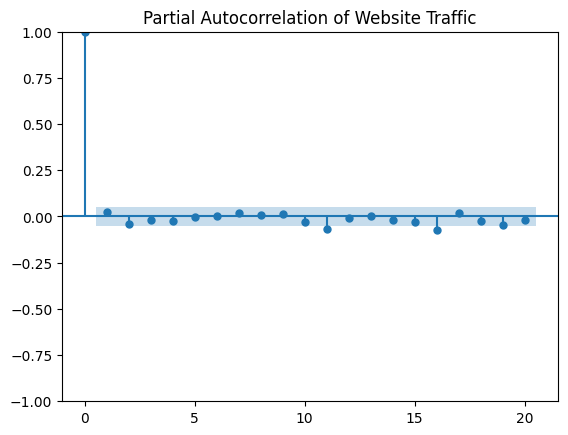

In [142]:
#Plot the PACF values
pacf_values_website_traffic = plot_pacf(website_traffic['Daily_Visitors'],lags=20,title='Partial Autocorrelation of Website Traffic')

In [143]:
# AR (p) orders
p_orders_website_traffic = [1,11,13,14,15]

#### d order for website traffic

In [144]:
# Determine the stationarity of website traffic
adf_test(website_traffic['Daily_Visitors'])

ADF Statistic:  -27.709067671015653
P-Value:  0.0
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


The time series is thus stationary due to the reduced p-value.

In [145]:
# Order for d
d_orders_website_traffic = [0,1]

In [147]:
warnings.filterwarnings("ignore")
# Looking at the best AR, MA, And d components for ARIMA models
model_arima = evaluate_time_series_models(website_traffic['Daily_Visitors'], p_orders_website_traffic, q_orders_website_traffic, d_orders_website_traffic)
model_arima.head()

,Model,Order,AIC,BIC
5,MA,"(0, 0, 1)",11987.424304,12003.284933
0,AR,"(1, 0, 0)",11987.507785,12003.368414
33,ARIMA,"(1, 1, 1)",11987.553773,12003.412348
29,ARIMA,"(1, 0, 1)",11988.324175,12009.471681
9,ARMA,"(1, 0, 1)",11988.324175,12009.471681


Based on these findings, it appears that we should choose ARIMA(11,1,1). Let's now assess without the seasonality component to compare.

In [148]:
# Removing seasonality from the website traffic data
weekly_website_traffic_seasonally_adjusted = weekly_website_traffic_decomposition[0] - weekly_website_traffic_decomposition[2]
weekly_website_traffic_seasonally_adjusted

Day
2020-01-01    202.863135
2020-01-02    204.774536
2020-01-03    198.843171
2020-01-04    196.997063
2020-01-05    238.802695
                 ...    
2023-12-27    185.863135
2023-12-28    202.774536
2023-12-29    235.843171
2023-12-30    193.997063
2023-12-31    207.802695
Length: 1461, dtype: float64

#### Q orders for Website Traffic:

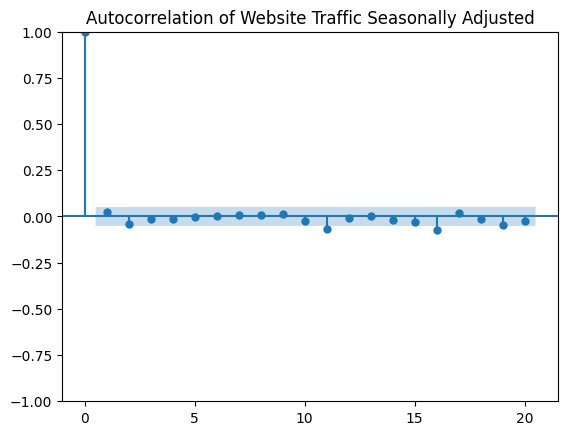

In [149]:
#Plot the ACF values
acf_values_website_traffic_seasonally_adjusted = plot_acf(weekly_website_traffic_seasonally_adjusted,lags=20,title='Autocorrelation of Website Traffic Seasonally Adjusted')

In [150]:
# Q orders
Q_orders_website_traffic = [2,11,16,19]

#### P orders for Website Traffic:

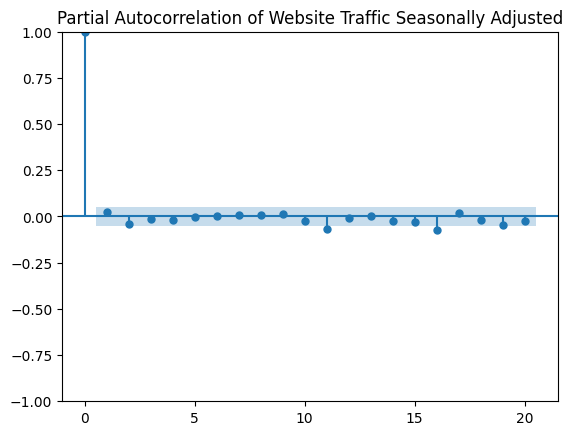

In [151]:
#Plot the PACF values
pacf_values_website_traffic_seasonally_adjusted = plot_pacf(weekly_website_traffic_seasonally_adjusted,lags=20,title='Partial Autocorrelation of Website Traffic Seasonally Adjusted')

In [152]:
# P orders
P_orders_website_traffic = [2,11,16,19]

#### D orders for Website Traffic:

In [153]:
# Determine the stationarity of website traffic
adf_test(weekly_website_traffic_seasonally_adjusted)

ADF Statistic:  -27.720690709524302
P-Value:  0.0
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [156]:
# D orders
D_orders_website_traffic = [0,1]

In [157]:
warnings.filterwarnings("ignore")
# Finding the best SARIMA model
select_best_sarima_model(website_traffic['Daily_Visitors'], p_orders_website_traffic, d_orders_website_traffic, q_orders_website_traffic, P_orders_website_traffic, D_orders_website_traffic, Q_orders_website_traffic, 12)

{'aic': 11986.497769012221,
 'bic': 11997.071521835724,
 'pdq': (0, 0, 0),
 'seasonal_pdq': (0, 0, 0, 12)}

#### Best Model Selection:
ARIMA = (11,1,1)
- AIC: 596.082937
- BIC: 620.134856

SARIMA = (0,0,0) (0,0,0,12)
- AIC: 11986.497769012221,
- BIC: 11997.071521835724

We will proceed with the ARIMA model for this website traffic dataset prediction.

### Forecasting:

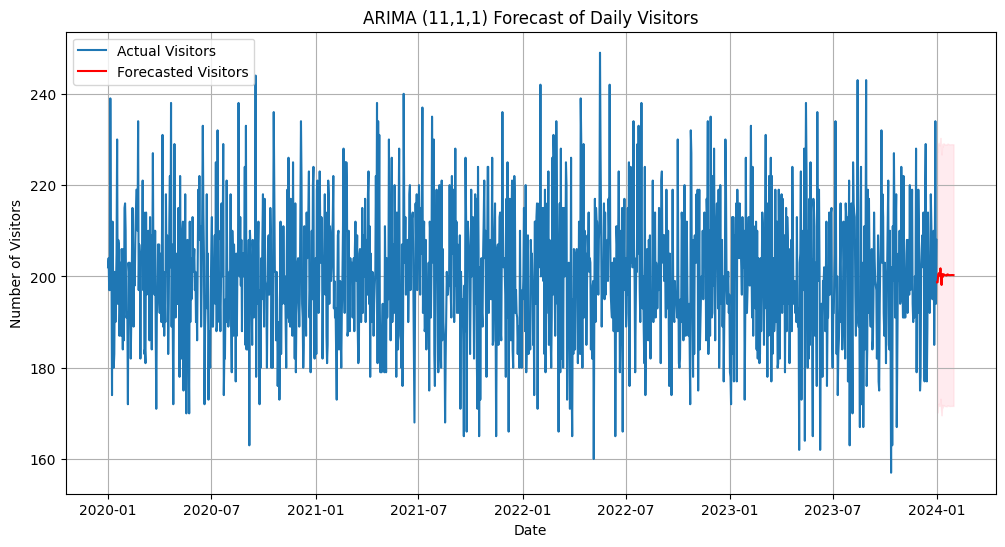

In [194]:
# Fit the ARIMA(11,1,1) model
model = ARIMA(website_traffic['Daily_Visitors'], order=(11, 1, 1))
model_fit = model.fit()

# Forecast the next 30 days
forecast_result = model_fit.get_forecast(steps=30)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Plotting the forecast alongside the actual data
plt.figure(figsize=(12, 6))
plt.plot(website_traffic['Daily_Visitors'], label='Actual Visitors')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Visitors', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA (11,1,1) Forecast of Daily Visitors')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)
plt.show()


### Model Evaluation:

In [195]:
from math import sqrt
# Split the data into training and testing sets
train_size = int(len(website_traffic) * 0.8)
train, test = website_traffic.iloc[:train_size], website_traffic.iloc[train_size:]

# Fit the model on the training data
model_train = ARIMA(train['Daily_Visitors'], order=(11,1,1))
model_train_fit = model_train.fit()

# Forecast on the test data
forecast_steps = len(test)  # Number of steps to forecast is the size of the test set
forecast_result_test = model_train_fit.get_forecast(steps=forecast_steps)
forecast_mean_test = forecast_result_test.predicted_mean

# Calculating MAE and RMSE
mae = mean_absolute_error(test['Daily_Visitors'], forecast_mean_test)
rmse = sqrt(mean_squared_error(test['Daily_Visitors'], forecast_mean_test))

mae, rmse


(12.504763774837157, 15.627910176926804)

- Model Evaluation and Limitations:
  - MAE of 12.50: This means, on average, the predictions deviate from the actual visitor numbers by about 12 visitors per day.
  - RMSE of 15.63: This metric gives us an idea of the error distribution and is more sensitive to large errors. The square root in RMSE gives it the same units as the output (visitors in this case), indicating that typical prediction errors are about 16 visitors per day.
- Limitations and Discrepancies:
  - Model Complexity: ARIMA(11,1,1) involves many lagged terms (11 AR terms), which can make the model complex and potentially overfit to the historical data, especially if the series does not inherently depend on so many past values.
  - Convergence Issues: As indicated by the warnings during model fitting, the optimizer had difficulty converging, which might suggest that the model's parameterization is not ideal or the data does not support such a detailed ARIMA model.
  - Stationarity Assumption: While the ADF test indicated stationarity, ARIMA models are sensitive to non-stationary data, and any underlying trends or seasonalities not captured by the model could lead to inaccuracies.
  - Future Data Unavailability: The model's accuracy assessment is based only on historical data since future actual data is not available. Therefore, the forecast should be treated with caution.